In [1]:
import json
import random
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.stats

from pathlib import Path
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from collections import Counter, defaultdict
plt.rcParams["figure.figsize"] = (20, 5)

## Functions

In [2]:
def get_plot_data(dir_path, from_number = 0, to_number = 10):
    num_dirs = len(os.listdir(dir_path))
    dirs = [dir_path / f'sim_{i}' for i in range(num_dirs)]
    markets, agents, rl_states, lengths, timesteps = [], [], [], [], []
    for _dir in dirs[from_number:to_number]:
        security_path = _dir / "TSMC.json"
        agent_path = _dir / "agent.json"
        rl_path = _dir / 'rl_agent.json'
        config_path = _dir / 'config.json'
        market = json.loads(security_path.read_text())
        markets.append(market)
        agents.append(json.loads(agent_path.read_text()))
        rl_states.append(json.loads(rl_path.read_text()))
        lengths.append(len(market['price']))
        timesteps.append([i for i in range(len(market['price']))])
    print(f"Simulation times: {len(dirs)}")
    print(f"Average training length: {sum(lengths) / len(lengths)}")
    return markets, agents, rl_states, lengths, timesteps

def plot_market(markets):
    avg_prices, avg_values = [], []
    avg_bids, avg_asks = [], []

    for i, market in enumerate(markets):
        plt.plot(market['price'], label = f"sim_{i}")
        
        
    plt.legend()
    plt.title("Prices by time")
    plt.show()

    for i, market in enumerate(markets):
        plt.plot(market['price'], label = "price")    
        plt.plot(market['value'], label = "value")
        plt.legend()
        plt.show()
        avg_prices.append(sum(market['price']) / len(market['price']))
        avg_values.append(sum(market['value']) / len(market['value']))
        avg_bids.append(sum(market['bid']) / len(market['bid']))
        avg_asks.append(sum(market['ask']) / len(market['ask']))

        
    plt.plot(avg_prices, label = 'Price')
    plt.plot(avg_values, label = 'Value')
    plt.legend()
    plt.title("Average price and value by time")
    plt.show()

    plt.plot(avg_bids, label = 'Bid')
    plt.plot(avg_asks, label = 'Ask')
    plt.legend()
    plt.title("Average bid and ask by time")
    plt.show()
#     print(f"Average step per bid quantity per agent: {1 / (sum([sum(market['bid']) / len(market['bid']) for market in markets]) / len(markets) / agent_number)}")
#     print(f"Average step per ask quantity per agent: {1 / (sum([sum(market['ask']) / len(market['ask']) for market in markets]) / len(markets) / agent_number)}")
    
def plot_total_distribution_of_return(rl_states):
    all_agent_returns = []
    for rl_state in rl_states:
        for agent_state in rl_state.values():
            returns = (agent_state['states'][-1]['agent_state']['wealth'] - agent_state['states'][0]['agent_state']['wealth']) / agent_state['states'][0]['agent_state']['wealth']
            all_agent_returns.append(round(returns * 100))
    num_pos_returns = len([ret for ret in all_agent_returns if ret > 0])
    num_neg_returns = len([ret for ret in all_agent_returns if ret < 0])
    agent_returns_counter = Counter(all_agent_returns)
    returns_x = sorted(agent_returns_counter.keys())
    returns_y = [agent_returns_counter[x] for x in returns_x]
    plt.scatter(returns_x, returns_y)
    print(f"Rate of positive returns: {num_pos_returns / (num_pos_returns + num_neg_returns)}")
    print(f"Rate of negtive returns: {num_neg_returns / (num_pos_returns + num_neg_returns)}")
    
def plot_distribution_of_return_by_agent(rl_states):
    agent_ids = rl_states[0].keys()
    agent_returns = {agent_id: [] for agent_id in agent_ids}

    for rl_state in rl_states:
        for agent_id, agent_state in rl_state.items():
            returns = (agent_state['states'][-1]['agent_state']['wealth'] - agent_state['states'][0]['agent_state']['wealth']) / agent_state['states'][0]['agent_state']['wealth']
            agent_returns[agent_id].append(round(returns * 100))
    avg_agent_returns = [round(sum(agent_return) / len(agent_return)) for agent_return in agent_returns.values()]
    agent_returns_counter = Counter(avg_agent_returns)
    returns_x = sorted(agent_returns_counter.keys())
    returns_y = [agent_returns_counter[x] for x in returns_x]
    plt.scatter(returns_x, returns_y)
    plt.title('Returns by agent')
    
    plt.figure(figsize=(40, 10))
    returns_progress = [returns[-1] - returns[0] for returns in agent_returns.values()]
    plt.scatter(list(range(len(returns_progress))), returns_progress)
    num_pos_progress = len([progress for progress in returns_progress if progress > 0])
    num_neg_progress = len([progress for progress in returns_progress if progress < 0])
    print(f"Positive progress: {num_pos_progress / len(returns_progress)}")
    print(f"Negative progress: {num_neg_progress / len(returns_progress)}")
#     return agent_returns

    
def plot_average_loss_by_time(rl_states, markets, agent_ids):
    # Agent average loss
    total_policy_loss = {}
    total_value_loss = {}
    length = len(markets[0]['price'][100:])
    for agent_id in agent_ids:
        agent_policy_losses = []
        agent_value_losses = []
        for states in rl_states:
            agent_policy_loss = sum(states[agent_id]['policy_loss'])
            agent_value_loss = sum(states[agent_id]['value_loss'])
            agent_policy_losses.append(agent_policy_loss)
            agent_value_losses.append(agent_value_loss)
        total_policy_loss[agent_id] = agent_policy_losses
        total_value_loss[agent_id] = agent_value_losses

    avg_policy_loss = [sum([total_policy_loss[agent_id][i] for agent_id in agent_ids]) / len(agent_ids) for i in range(len(rl_states))]
    avg_value_loss = [sum([total_value_loss[agent_id][i] for agent_id in agent_ids]) / len(agent_ids) for i in range(len(rl_states))]
    plt.plot(avg_policy_loss)
    plt.show()
    plt.plot(avg_value_loss)

def plot_reward_by_time(rl_states, agent_id):
    total_rewards = []
    for _, states in enumerate(rl_states):
        total_reward, wealth_reward, action_reward, strategy_reward = [], [], [], []

        for reward in states[agent_id]['rewards']:
            total_reward.append(reward['weighted_reward'])
            wealth_reward.append(reward['wealth_reward'])
            strategy_reward.append(reward['strategy_reward'])
        
        total_rewards.append(sum(total_reward))
    plt.plot(total_rewards)
    plt.show()
            
    for _, states in enumerate(rl_states):
        total_reward, wealth_reward, action_reward, strategy_reward = [], [], [], []

        for reward in states[agent_id]['rewards']:
            total_reward.append(reward['weighted_reward'])
            wealth_reward.append(reward['wealth_reward'])
            strategy_reward.append(reward['strategy_reward'])
        
        print(f"Total reward: {sum(total_reward)}\nWealth reward: {sum(wealth_reward)}\nStrategy reward: {sum(strategy_reward)}")
        
        for label, value in zip(['Total', 'Wealth', 'Action', 'Strategy'], [total_reward, wealth_reward, action_reward, strategy_reward]):
            plt.plot(value, label = label)
        plt.legend()
        plt.show()

        wealth_weight = {'short': 0.35, 'mid': 0.25, 'long': 0.25, 'base': 0.15}
        short_steps = 20
        mid_steps = 60
        long_steps = 250
        risk_free_rate = 0.0002
        rewards = []
        short_changes, mid_changes, long_changes, base_changes = [], [], [], []
        risk_free_return = [risk_free_rate]
        for i, state in enumerate(states[agent_id]['states']):
            total_steps = i+1
            present_wealth = state['agent_state']['wealth']
            base_wealth = states[agent_id]['states'][0]['agent_state']['wealth']
            short_wealths = [present_wealth] + [s['agent_state']['wealth'] for s in states[agent_id]['states'][:i][-short_steps:]]
            short_wealth = sum(short_wealths) / len(short_wealths)
            mid_wealths = [present_wealth] + [s['agent_state']['wealth'] for s in states[agent_id]['states'][:i][-mid_steps:]]
            mid_wealth = sum(mid_wealths) / len(mid_wealths)
            long_wealths = [present_wealth] + [s['agent_state']['wealth'] for s in states[agent_id]['states'][:i][-long_steps:]]
            long_wealth = sum(long_wealths) / len(long_wealths)

            short_change = (present_wealth - short_wealth) / short_wealth - pow(risk_free_rate, short_steps)
            mid_change = (present_wealth - mid_wealth) / mid_wealth - pow(risk_free_rate, mid_steps)
            long_change = (present_wealth - long_wealth) / long_wealth - pow(risk_free_rate, long_steps)
            base_change = (present_wealth - base_wealth) / base_wealth - pow(risk_free_rate, i)
            risk_free_return.append((1 + risk_free_return[-1]) * (1 + risk_free_rate) - 1)
            short_changes.append(short_change)
            mid_changes.append(mid_change)
            long_changes.append(long_change)
            base_changes.append(base_change)

            wealth_reward = 10 * (wealth_weight['short']*short_change + wealth_weight['mid']*mid_change + wealth_weight['long']*long_change + wealth_weight['base']*base_change)
            rewards.append(wealth_reward)

        plt.plot(short_changes, label='short', color = 'r')
        plt.plot(mid_changes, label='mid', color = 'g')
        plt.plot(long_changes, label='long', color = 'b')
        plt.plot(base_changes, label='base', color = 'k')
        plt.plot(risk_free_return, label='risk_free_return', color = 'y')
        plt.axhline(y = pow(1+risk_free_rate, short_steps)-1, linestyle='-', color = 'r')
        plt.axhline(y = pow(1+risk_free_rate, mid_steps)-1, linestyle='-', color = 'g')
        plt.axhline(y = pow(1+risk_free_rate, long_steps)-1, linestyle='-', color = 'b')
        plt.legend()
        plt.show()

def sample_agent_id(group_name, agent_number):
    return f"{group_name}_{random.randint(0, agent_number - 1)}"

def plot_wealth_by_time(rl_states, agent_id):    
    for i, rl_state in enumerate(rl_states):
        agent_state = rl_state[agent_id]['states']
        cash = [state['agent_state']['cash'] for state in agent_state]
        holding = [state['agent_state']['TSMC'] for state in agent_state]
        wealth = [state['agent_state']['wealth'] for state in agent_state]
        plt.plot(wealth, label = f"sim_{i}")
        plt.title('Wealth')
        plt.legend()
        
def plot_holdings(rl_states, agent_id):
    # Holdings
    agent_state = rl_states[-1][agent_id]['states']
    cash = [state['agent_state']['cash'] for state in agent_state]
    holding = [state['agent_state']['TSMC'] for state in agent_state]
    wealth = [state['agent_state']['wealth'] for state in agent_state]
    plt.plot(cash, label = "Cash")
    plt.plot(wealth, label = "Wealth")
    plt.legend()
    plt.show()
    plt.plot(holding, label = "TSMC")
    plt.legend()

def plot_loss(rl_states, agent_id):
    policy_loss = []
    value_loss = []
    for i, states in enumerate(rl_states):

        policy_loss += states[agent_id]['policy_loss']
        value_loss += states[agent_id]['value_loss']

    plt.plot(policy_loss, label = f"Policy loss")
    plt.legend()
    plt.show()

    plt.plot(value_loss, label = f"Value loss")
    plt.legend()
    plt.show()
def plot_action(rl_states, markets, agent_id):
    # sample agent to analyse
    action_ref = {0: "BID", 1: "ASK", 2: "HOLD"}
    tick_ref = {i: tick for i, tick in zip(list(range(0, 9)), list(range(-4, 5)))}
    print(agent_id)
    for state, market in zip(rl_states, markets):
        orders = []
        counter = {"BID": 0, "ASK": 0, "HOLD": 0}
        for i, action in enumerate(state[agent_id]['actions']):
            bid_or_ask = action_ref[action[0]]
            ticks = 1
            price = market['price'][99+i] + tick_size * ticks
            volume = 1
            order = {'time': i, "bid_or_ask": bid_or_ask, "price": price, "volume": volume}
            counter[bid_or_ask] += 1
            orders.append(order)

        total_actions = sum(counter.values())
        print(counter)
        print(f"Bid: {counter['BID'] / total_actions}\nAsk: {counter['ASK'] / total_actions}\nHold: {counter['HOLD'] / total_actions}")
        bid_x, bid_y = [], []
        ask_x, ask_y = [], []
        bid_sizes, ask_sizes = [], []
        bid_colors, ask_colors = [], []
        base_size = 10
        for i, order in enumerate(orders):
            if order['bid_or_ask'] == 'BID':
        #         if order['time'] > 5000 and order['time'] < 5100:
                bid_x.append(order['time'])
                bid_y.append(order['price'])
                bid_colors.append('r')
                bid_sizes.append(base_size * order['volume'])
            if order['bid_or_ask'] == 'ASK':
        #         if order['time'] > 5000 and order['time'] < 5100:
                ask_x.append(order['time'])
                ask_y.append(order['price'])
                ask_colors.append('g')  
                ask_sizes.append(base_size * order['volume'])
        plot_price = market['price'][100:]
        plot_value = market['value'][100:]
        x = np.arange(len(plot_price))
        plt.figure(figsize=(80, 20))
        plt.plot(x, plot_price, label = "price")
        plt.plot(x, plot_value, label = "value")
        plt.legend()
        plt.scatter(bid_x, bid_y, s = bid_sizes, c = bid_colors, marker = 6)
        plt.scatter(ask_x, ask_y, s = ask_sizes, c = ask_colors, marker = 7)
        plt.show()
def plot_action_with_reward(rl_states, markets, agent_id):
    # sample agent to analyse
    action_ref = {0: "BID", 1: "ASK", 2: "HOLD"}
    tick_ref = {i: tick for i, tick in zip(list(range(0, 9)), list(range(-4, 5)))}
    print(agent_id)
    for state, market in zip(rl_states, markets):
        orders = []
        counter = {"BID": 0, "ASK": 0, "HOLD": 0}
        for i, action in enumerate(state[agent_id]['actions']):
            bid_or_ask = action_ref[action[0]]
            ticks = 1
            price = market['price'][99+i] + tick_size * ticks
            volume = 1
            order = {'time': i, "bid_or_ask": bid_or_ask, "price": price, "volume": volume}
            counter[bid_or_ask] += 1
            orders.append(order)

        total_actions = sum(counter.values())
        print(counter)
        print(f"Bid: {counter['BID'] / total_actions}\nAsk: {counter['ASK'] / total_actions}\nHold: {counter['HOLD'] / total_actions}")
        bid_x, bid_y = [], []
        ask_x, ask_y = [], []
        bid_sizes, ask_sizes = [], []
        bid_colors, ask_colors = [], []
        base_size = 10
        for i, order in enumerate(orders):
            if order['bid_or_ask'] == 'BID':
        #         if order['time'] > 5000 and order['time'] < 5100:
                bid_x.append(order['time'])
                bid_y.append(order['price'])
                bid_colors.append('r')
                bid_sizes.append(base_size * order['volume'])
            if order['bid_or_ask'] == 'ASK':
        #         if order['time'] > 5000 and order['time'] < 5100:
                ask_x.append(order['time'])
                ask_y.append(order['price'])
                ask_colors.append('g')  
                ask_sizes.append(base_size * order['volume'])
        plot_price = market['price'][100:]
        plot_value = market['value'][100:]
        x = np.arange(len(plot_price))
        plt.figure(figsize=(80, 20))
        plt.plot(x, plot_price, label = "price")
        plt.plot(x, plot_value, label = "value")
        plt.legend()
        plt.scatter(bid_x, bid_y, s = bid_sizes, c = bid_colors, marker = 6)
        plt.scatter(ask_x, ask_y, s = ask_sizes, c = ask_colors, marker = 7)
        plt.show()

        total_reward, wealth_reward, action_reward, strategy_reward = [], [], [], []

        for reward in state[agent_id]['rewards']:
            total_reward.append(reward['weighted_reward'])
            wealth_reward.append(reward['wealth_reward'])
            strategy_reward.append(reward['strategy_reward'])

        for label, value in zip(['Total', 'Wealth', 'Action', 'Strategy'], [total_reward, wealth_reward, action_reward, strategy_reward]):
            plt.plot(value, label = label)
        plt.legend()
        plt.show()
    #     weighted_reward = [reward['weighted_reward'] for reward in rl_state[agent_id]['rewards']]
    #     wealth_reward = [reward['wealth_reward'] for reward in rl_state[agent_id]['rewards']]
    #     strategy_reward = [reward['straty'] for reward in rl_state[agent_id]['rewards']]
    #     plt.plot(weighted_reward, label = "Total reward")
    #     plt.plot(wealth_reward, label = "Wealth reward")
    #     plt.plot(strategy_reward, label = "Strategy reward")
    #     plt.legend()
    #     plt.show()

def plot_action_with_state(rl_states, markets, agent_id):
    # sample agent to analyse
    action_ref = {0: "BID", 1: "ASK", 2: "HOLD"}
    tick_ref = {i: tick for i, tick in zip(list(range(0, 9)), list(range(-4, 5)))}
    print(agent_id)
    for state, market in zip(rl_states, markets):
        orders = []
        counter = {"BID": 0, "ASK": 0, "HOLD": 0}
        for i, action in enumerate(state[agent_id]['actions']):
            bid_or_ask = action_ref[action[0]]
            ticks = 1
            price = market['price'][99+i] + tick_size * ticks
            volume = 1
            order = {'time': i, "bid_or_ask": bid_or_ask, "price": price, "volume": volume}
            counter[bid_or_ask] += 1
            orders.append(order)

        total_actions = sum(counter.values())
        print(counter)
        print(f"Bid: {counter['BID'] / total_actions}\nAsk: {counter['ASK'] / total_actions}\nHold: {counter['HOLD'] / total_actions}")
        bid_x, bid_y = [], []
        ask_x, ask_y = [], []
        bid_sizes, ask_sizes = [], []
        bid_colors, ask_colors = [], []
        base_size = 10
        for i, order in enumerate(orders):
            if order['bid_or_ask'] == 'BID':
        #         if order['time'] > 5000 and order['time'] < 5100:
                bid_x.append(order['time'])
                bid_y.append(order['price'])
                bid_colors.append('r')
                bid_sizes.append(base_size * order['volume'])
            if order['bid_or_ask'] == 'ASK':
        #         if order['time'] > 5000 and order['time'] < 5100:
                ask_x.append(order['time'])
                ask_y.append(order['price'])
                ask_colors.append('g')  
                ask_sizes.append(base_size * order['volume'])
        plot_price = market['price'][100:]
        plot_value = market['value'][100:]
        x = np.arange(len(plot_price))
        plt.figure(figsize=(80, 20))
        plt.plot(x, plot_price, label = "price")
        plt.plot(x, plot_value, label = "value")
        plt.legend()
        plt.scatter(bid_x, bid_y, s = bid_sizes, c = bid_colors, marker = 6)
        plt.scatter(ask_x, ask_y, s = ask_sizes, c = ask_colors, marker = 7)
        plt.show()

        
        total_reward, wealth_reward, action_reward, strategy_reward = [], [], [], []
        for reward in state[agent_id]['rewards']:
            total_reward.append(reward['weighted_reward'])
            wealth_reward.append(reward['wealth_reward'])
            strategy_reward.append(reward['strategy_reward'])

        for label, value in zip(['Total', 'Wealth', 'Action', 'Strategy'], [total_reward, wealth_reward, action_reward, strategy_reward]):
            plt.plot(value, label = label)
        plt.legend()
        plt.show()

def plot_action(rl_states, markets, agent_id):
    # sample agent to analyse
    action_ref = {0: "BID", 1: "ASK", 2: "HOLD"}
    tick_ref = {i: tick for i, tick in zip(list(range(0, 9)), list(range(-4, 5)))}
    print(agent_id)
    for state, market in zip(rl_states, markets):
        orders = []
        counter = {"BID": 0, "ASK": 0, "HOLD": 0}
        for i, action in enumerate(state[agent_id]['actions']):
            bid_or_ask = action_ref[action[0]]
            ticks = 1
            price = market['price'][99+i] + tick_size * ticks
            volume = 1
            order = {'time': i, "bid_or_ask": bid_or_ask, "price": price, "volume": volume}
            counter[bid_or_ask] += 1
            orders.append(order)

        total_actions = sum(counter.values())
        print(counter)
        print(f"Bid: {counter['BID'] / total_actions}\nAsk: {counter['ASK'] / total_actions}\nHold: {counter['HOLD'] / total_actions}")
        bid_x, bid_y = [], []
        ask_x, ask_y = [], []
        bid_sizes, ask_sizes = [], []
        bid_colors, ask_colors = [], []
        base_size = 10
        for i, order in enumerate(orders):
            if order['bid_or_ask'] == 'BID':
        #         if order['time'] > 5000 and order['time'] < 5100:
                bid_x.append(order['time'])
                bid_y.append(order['price'])
                bid_colors.append('r')
                bid_sizes.append(base_size * order['volume'])
            if order['bid_or_ask'] == 'ASK':
        #         if order['time'] > 5000 and order['time'] < 5100:
                ask_x.append(order['time'])
                ask_y.append(order['price'])
                ask_colors.append('g')  
                ask_sizes.append(base_size * order['volume'])
        plot_price = market['price'][100:]
        plot_value = market['value'][100:]
        x = np.arange(len(plot_price))
        plt.figure(figsize=(80, 20))
        plt.plot(x, plot_price, label = "price")
        plt.plot(x, plot_value, label = "value")
        plt.legend()
        plt.scatter(bid_x, bid_y, s = bid_sizes, c = bid_colors, marker = 6)
        plt.scatter(ask_x, ask_y, s = ask_sizes, c = ask_colors, marker = 7)
        plt.show()

        
        
def cal_good_action(rl_states, agent_id):
    for rl_state in rl_states:
        gaps = [state['observations'][1] for state in rl_state[agent_id]['states']]
#         prices = [state['observations'][1] for state in rl_state[agent_id]['states']]
#         wealths = [state['observations'][2] for state in rl_state[agent_id]['states']]
        actions = [action[0] for action in rl_state[agent_id]['actions']]

        expections = {'Good': 0, 'Bad': 0, 'Hold': 0}
        for gap, action in zip(gaps, actions):
            if gap >= 0:
                if action == 1:
                    expections['Good'] += 1
                elif action == 0:
                    expections['Bad'] += 1
                else:
                    expections['Hold'] += 1
            if gap < 0:
                if action == 0:
                    expections['Good'] += 1
                elif action == 1:
                    expections['Bad'] += 1
                else:
                    expections['Hold'] += 1
        print(f"Good: {expections['Good'] / len(gaps)}, Bad: {expections['Bad'] / len(gaps)}, Hold: {expections['Hold'] / len(gaps)}")
        
def cal_sc_good_action(rl_states, markets, sc_agent_id):
    for rl_state, market in zip(rl_states, markets):
    #     gaps = [state['observations'][1] for state in rl_state[agent_id]['states']]
    #         prices = [state['observations'][1] for state in rl_state[agent_id]['states']]
    #         wealths = [state['observations'][2] for state in rl_state[agent_id]['states']]

        gaps = [(price - value) / price for price, value in zip(market['price'][100:], market['value'][100:])]
        actions = [action[0] for action in rl_state[sc_agent_id]['actions']]

        expections = {'Good': 0, 'Bad': 0, 'Hold': 0}
        for gap, action in zip(gaps, actions):
            if gap >= 0:
                if action == 1:
                    expections['Good'] += 1
                elif action == 0:
                    expections['Bad'] += 1
                else:
                    expections['Hold'] += 1
            if gap < 0:
                if action == 0:
                    expections['Good'] += 1
                elif action == 1:
                    expections['Bad'] += 1
                else:
                    expections['Hold'] += 1
        no_hold = expections['Good'] + expections['Bad']
        print(f"Good: {expections['Good'] / no_hold}, Bad: {expections['Bad'] / no_hold}, Hold: {expections['Hold'] / len(gaps)}")

        
def get_max_return_agent_id(rl_states, _type = None):
    max_return, max_agent_id = 0, 0
    for agent_id, returns in agent_returns.items():
#         if not agent_id.startswith('ppo_tr'):
#             continue
        if sum(returns) >= max_return:
            max_agent_id = agent_id
            max_return = sum(returns)
    return max_agent_id, max_return

def plot_obs_action_reward(rl_states, agent_id, labels):
    for t in range(len(rl_states)):
        length = len(rl_states[t][agent_id]['states'])
        d_ps = [rl_states[t][agent_id]['states'][i]['observations'] for i in range(length)]
        actions = [rl_states[t][agent_id]['actions'][i][0]*0.1 for i in range(length)]
        rewards = [rl_states[t][agent_id]['rewards'][i]['weighted_reward'] for i in range(length)]
        plt.plot(d_ps, label = labels)
#         plt.plot(rewards, label = 'weighted_reward')
#         plt.scatter(list(range(length)), actions)
        plt.legend()
        plt.show()
        
def plot_obs_action(rl_states, agent_id, labels):
    for t in range(len(rl_states)):
        length = len(rl_states[t][agent_id]['states'])
        d_ps = [rl_states[t][agent_id]['states'][i]['observations'] for i in range(length)]
        actions = [rl_states[t][agent_id]['actions'][i][0]*0.1 for i in range(length)]
        plt.plot(d_ps, label = labels)
#         plt.scatter(list(range(length)), actions)
        plt.legend()
        plt.show()
                

### Research function

In [3]:
def plot_price_value(prices, values):
    plt.plot(prices, color = 'r', label = 'price')
    plt.plot(values, color = 'b', label = 'value')
    plt.xlabel('Time step', size = 14)
    plt.ylabel('Price & value', size = 14)
    plt.legend()
    plt.show()

    offset_price = [price + 20 for price in prices]
    plt.plot(offset_price, color = 'r', label = 'price')
    plt.plot(values, color = 'b', label = 'value')
    plt.xlabel('Time step', size = 14)
    plt.ylabel('Price & value', size = 14)
    plt.legend()
    plt.show()
    
def plot_diff_return(prices):
    log_prices = [math.log(price) for price in prices]
    lookback_list = [1, 2, 15, 25]
    marker_styles = {1: 'v', 2: 'o', 15: '*', 25: 'x'}
    normal_list = [round(abs(random.gauss(0, 1)), 2) for _ in range(400000)]
    returns_list = {'normal': normal_list}
    
    for lookback in lookback_list:
        returns = []
        for i in range(lookback, len(log_prices)):
            returns.append(log_prices[i] - log_prices[i-lookback])
        returns = (np.abs((np.array(returns) - np.mean(returns)) / np.std(returns))).round(2).tolist()
        returns_list[lookback] = returns
    
    
    plt.figure(figsize=(6, 5))
    for label, returns in returns_list.items():
        length = len(returns)
        returns_counter = Counter(returns)
        sorted_returns = sorted(list(returns_counter.keys()), reverse=True)
        accu_numbers = []
        for i, r in enumerate(sorted_returns):
            if i == 0:
                accu_numbers.append(returns_counter[r] / length)
            else:
                accu_numbers.append(returns_counter[r] / length + accu_numbers[i-1])
        plt.xscale("log", base = 10)
        plt.yscale("log", base = 10)
#         plt.gca().invert_xaxis()

        if label == 'normal':
            plt.plot(sorted_returns, accu_numbers, label = 'N(0, 1)', color = 'black')
        else:
            plt.scatter(sorted_returns, accu_numbers, label = f"τ={label}", marker = marker_styles[label], s = 5)
    plt.legend()
    plt.xlabel('Return')
    plt.ylabel('Prob (>|ret.|)')
    plt.show()
    
def plot_returns(prices, values):
    eps = 0.04
    plt.figure(figsize = (10, 2))
    plt.plot(np.diff(np.log(prices)), color = 'black')
    plt.ylim(-eps, eps)
    plt.xlabel('Time step', size = 12)
    plt.ylabel('Relative price chagne', size = 8)
    plt.show()
    
    plt.figure(figsize = (10, 2))
    plt.plot(np.diff(np.log(values)), color = 'black')
    plt.ylim(-eps, eps)
    plt.xlabel('Time step', size = 12)
    plt.ylabel('Relative value change', size = 8)

    plt.show()

## Call market

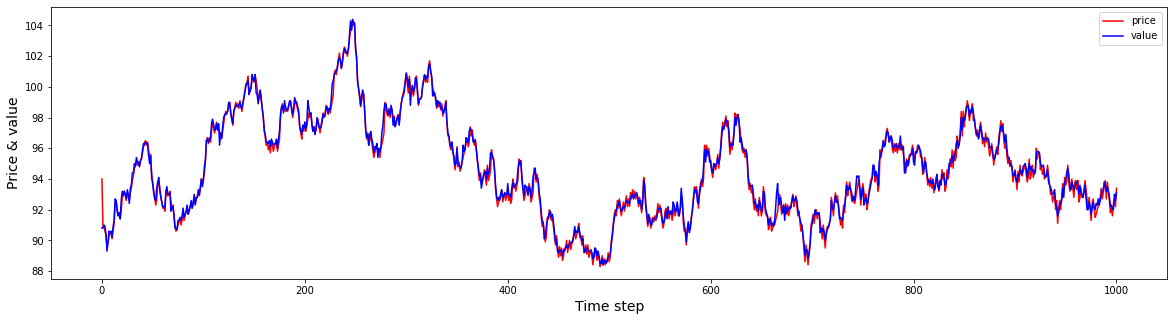

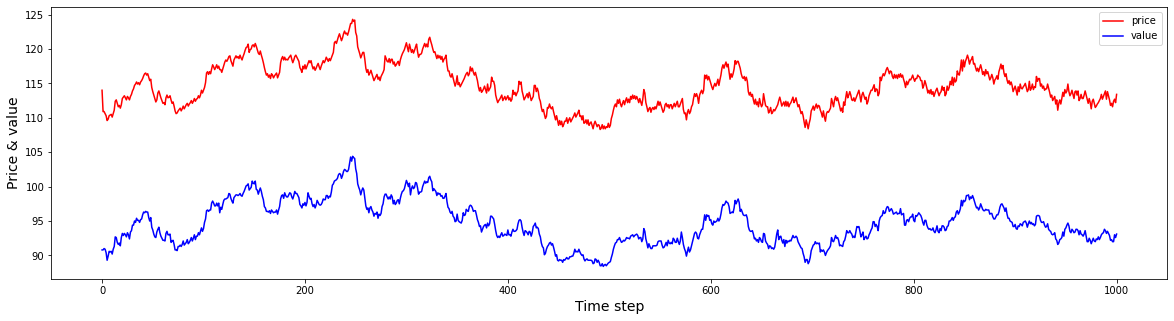

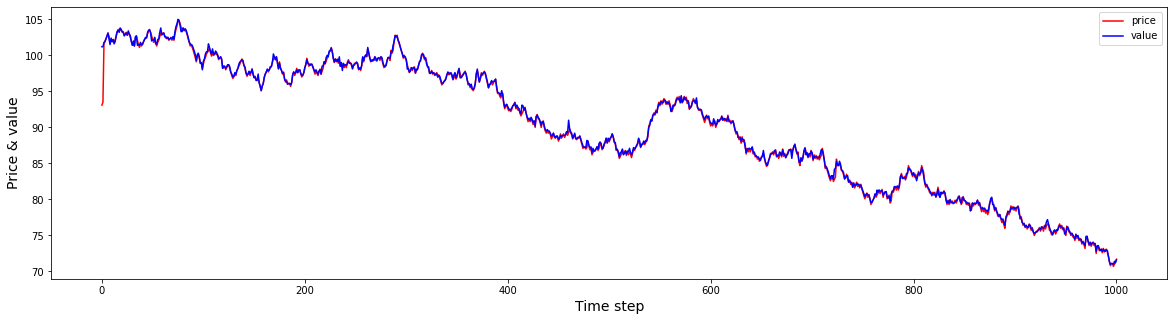

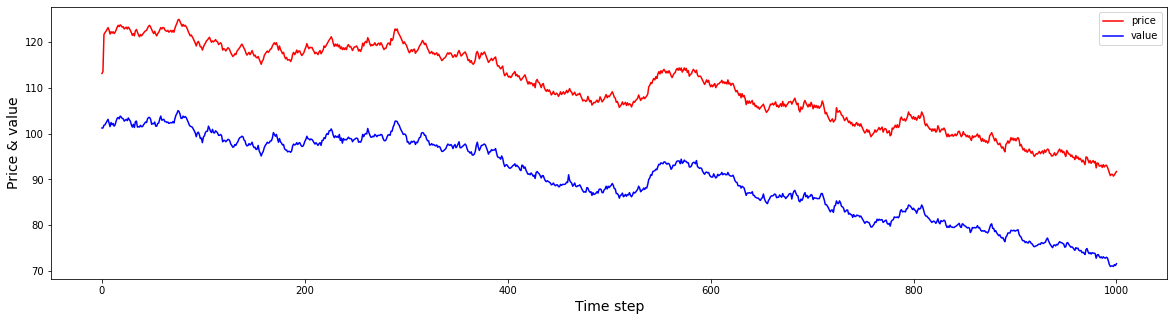

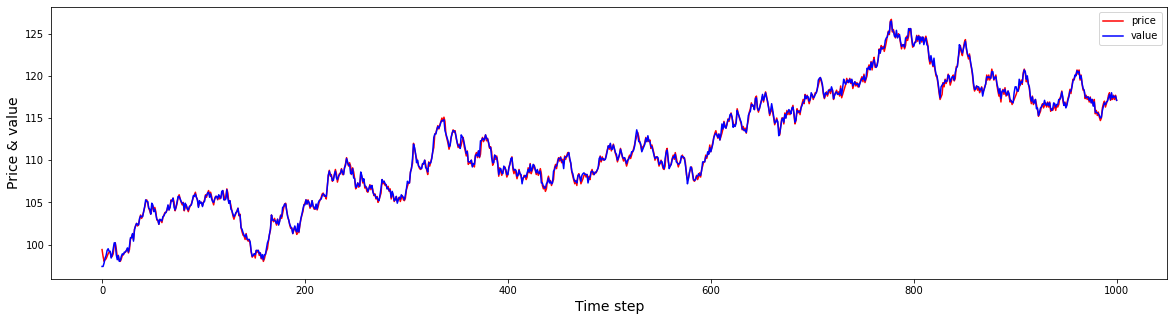

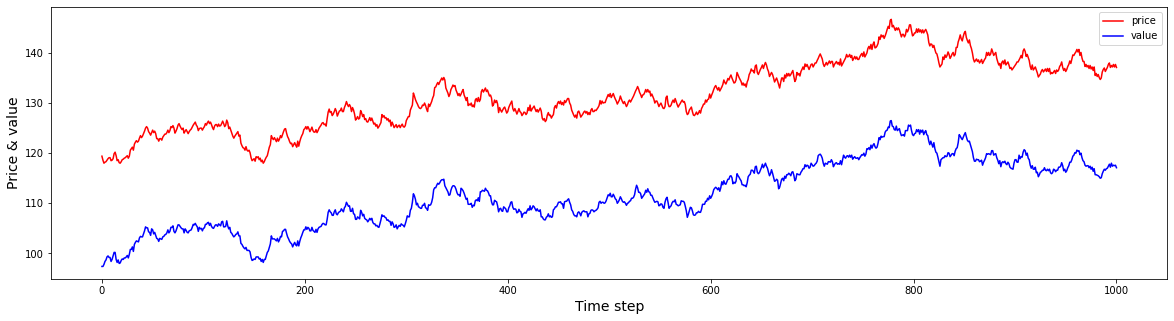

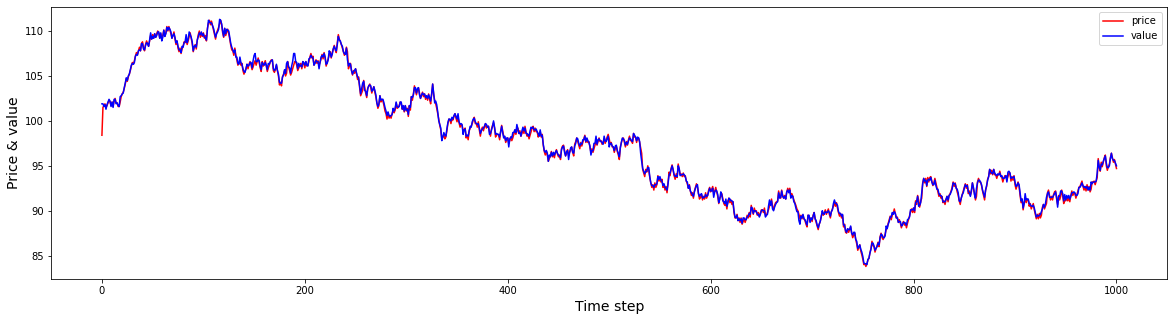

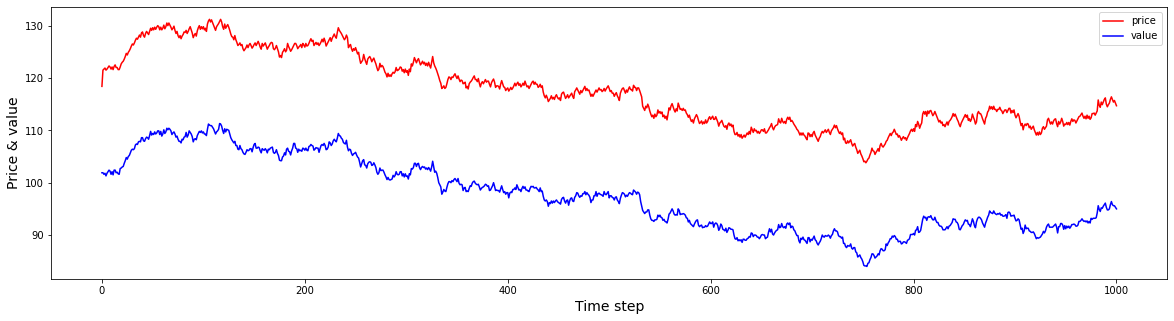

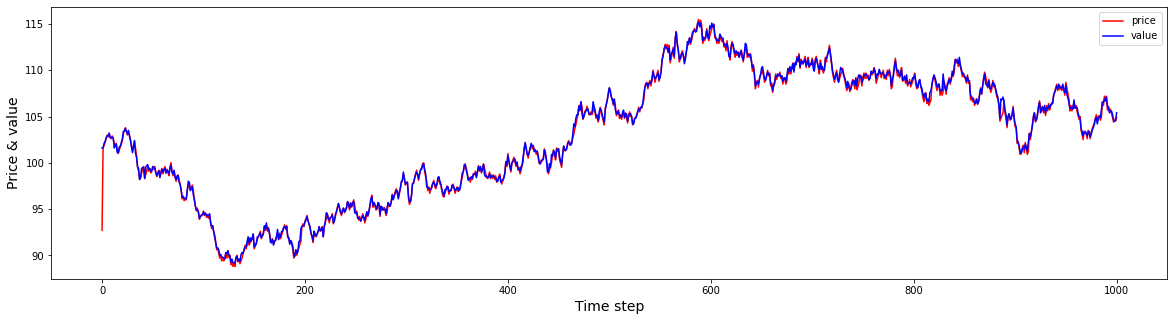

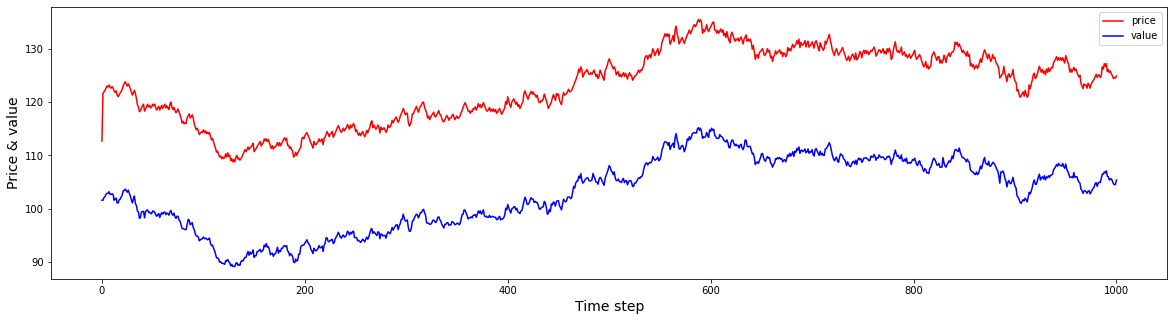

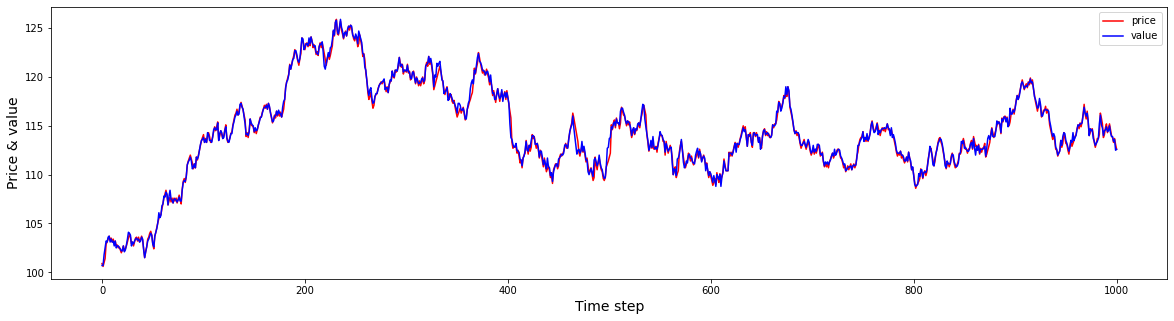

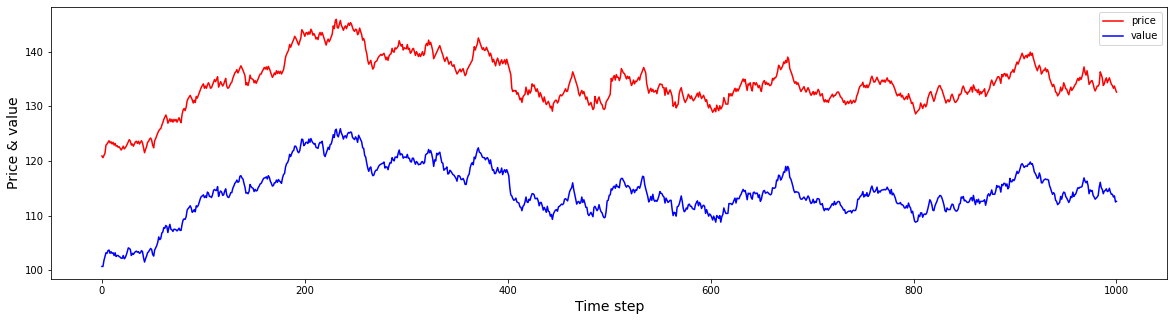

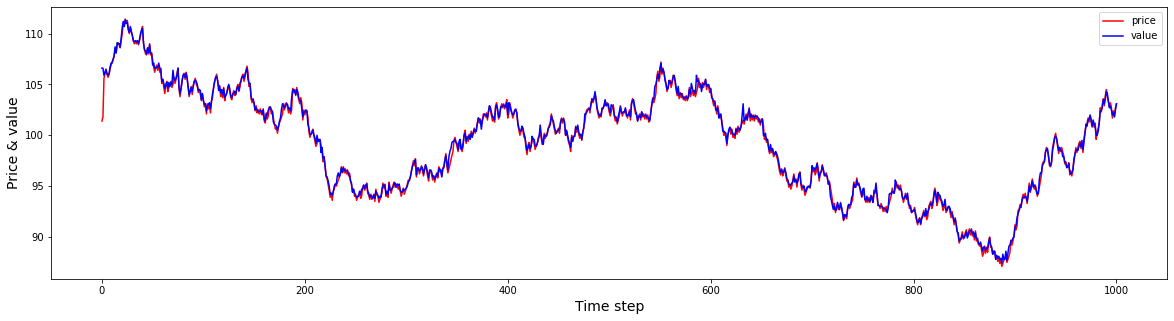

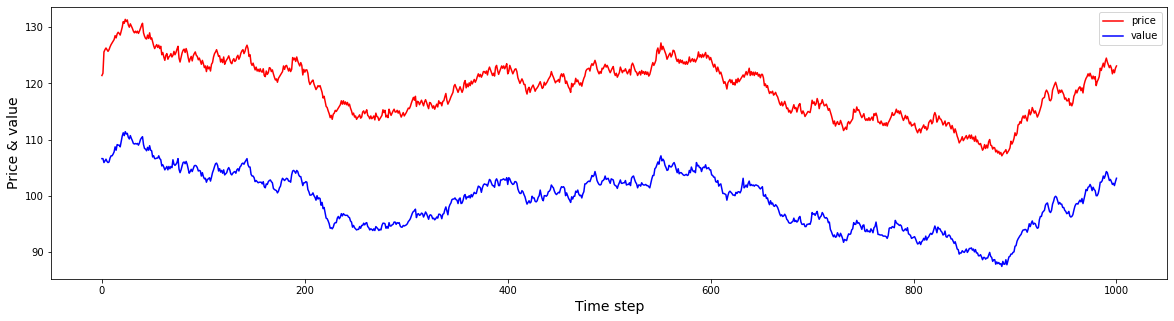

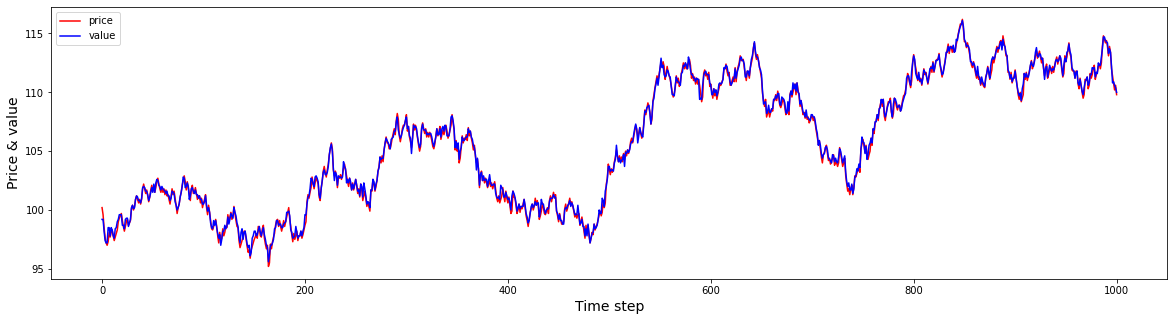

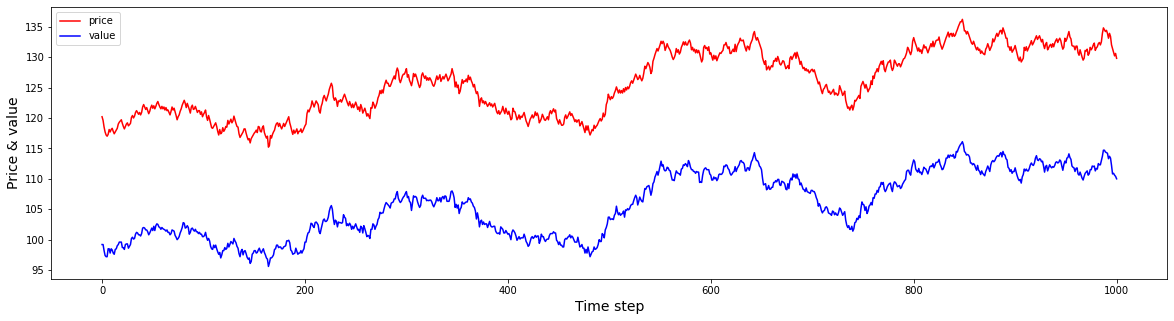

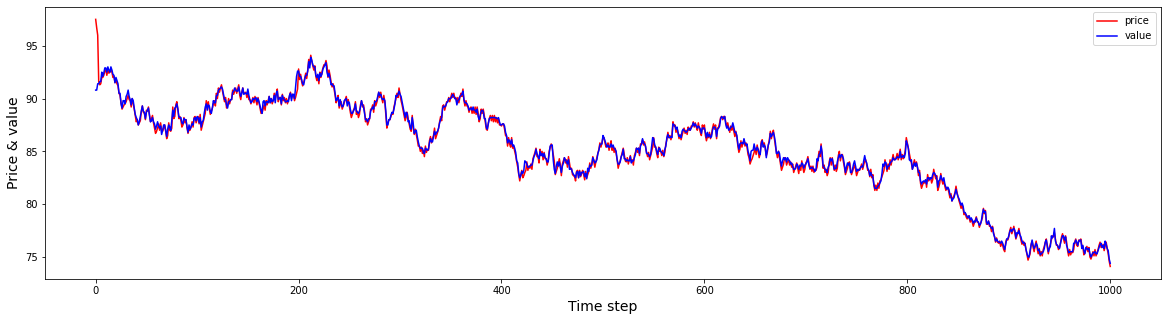

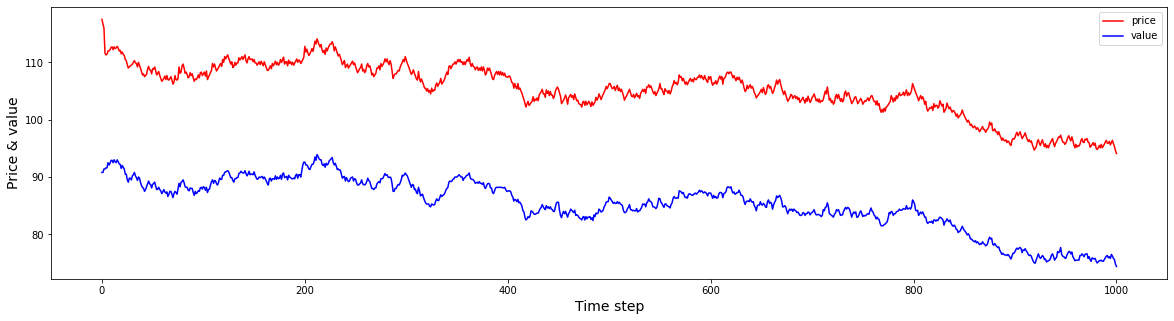

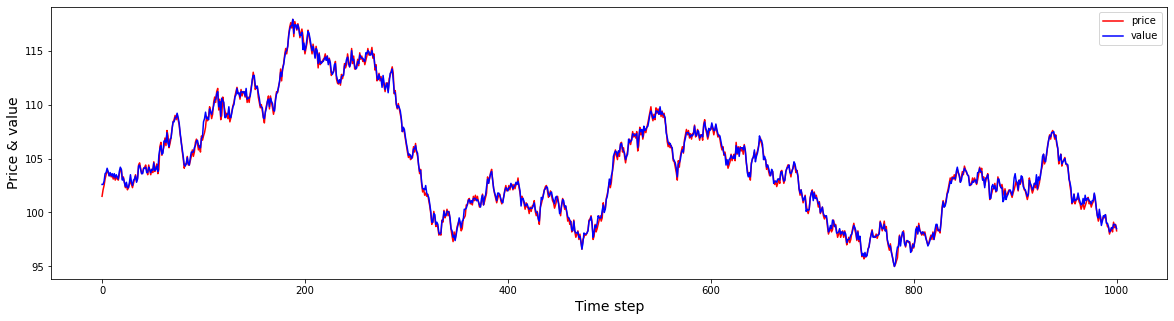

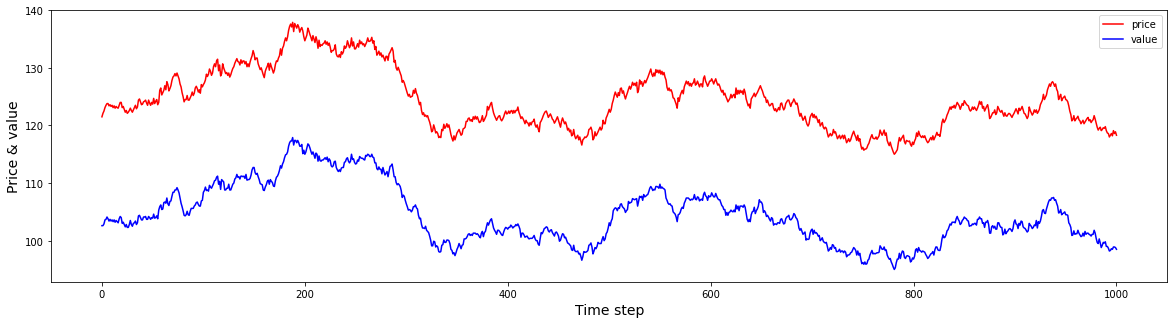

In [284]:
for i in range(10):
    tick_size = 0.1
    config_name = f"thesis_range5/sim_{i}"
    record_path = Path(f"simulation_result/call/{config_name}")
    security_path = record_path / 'TSMC.json'
    agent_path = record_path / 'agent.json'
    config_path = record_path / 'config.json'
    config = (json.loads(config_path.read_text()))

    market = json.loads(security_path.read_text())
    group_agent = json.loads(agent_path.read_text())
    prices = market['price'][100:]
    values = market['value'][100:]
    plot_price_value(prices, values)

In [ ]:
plot_price_value(prices, values)

In [ ]:
plot_returns(prices, values)

In [ ]:
plot_diff_return(prices)

In [ ]:
# fit fail
log_returns = np.diff(np.log(prices))
returns = (np.abs((np.array(log_returns) - np.mean(log_returns)) / np.std(log_returns))).round(1).tolist()
length = len(returns)
returns_counter = Counter(returns)
sorted_returns = sorted(list(returns_counter.keys()))
accu_numbers = []
for i, r in enumerate(sorted_returns):
    if i == 0:
        accu_numbers.append(returns_counter[r] / length)
    else:
        accu_numbers.append(returns_counter[r] / length + accu_numbers[i-1])
sorted_returns.pop(0)
return_dist = [returns_counter[r] for r in sorted_returns]
fit = np.polyfit(np.log(sorted_returns), np.log(return_dist), 1)
print(fit)
plt.scatter(np.log(sorted_returns), np.log(return_dist))

In [276]:
plt.plot(group_agent['sc_opt_125']['number'], label = 'opt')
plt.plot(group_agent['sc_pes_125']['number'], label = 'pes')
plt.plot(group_agent['sc_fud_250']['number'], label = 'fud')
plt.legend()

KeyError: 'number'

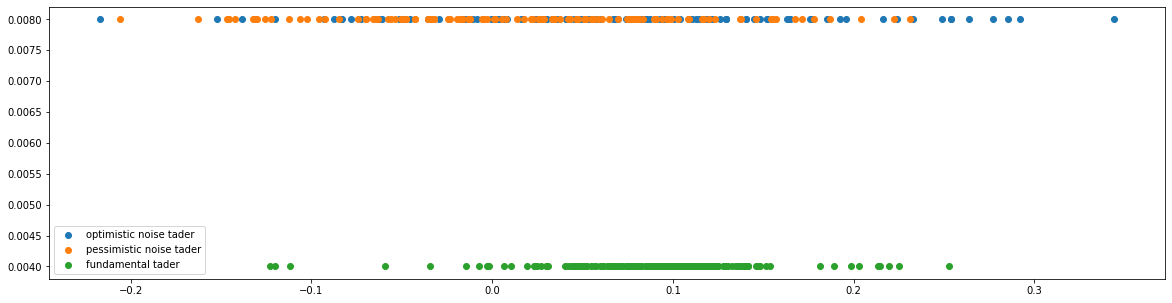

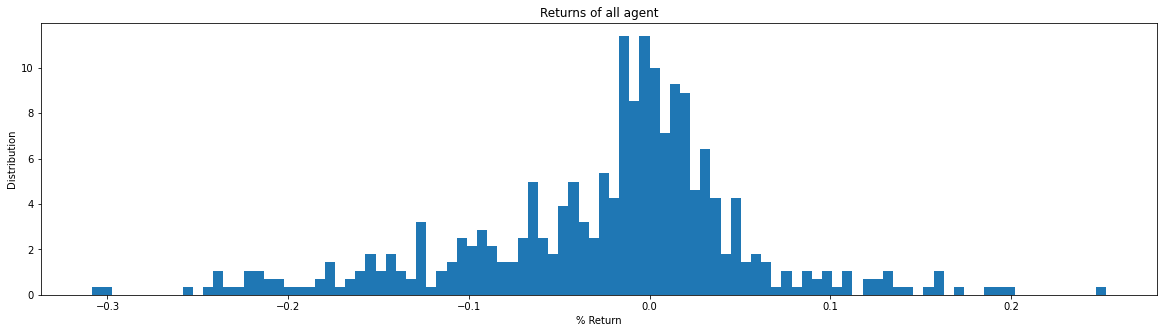

In [283]:
# distribution of returns of agent

def plot_agent_returns_distribution(group_agent):
    risk_free_rate = 0.0004
    timesteps = len(group_agent['sc_opt_125']['cash'])
    group_label = {'sc_opt_125': 'optimistic noise tader', 'sc_pes_125': 'pessimistic noise tader', 'sc_fud_250': 'fundamental tader'}
    for group, agents in group_agent.items():
        group_returns = agents['returns_by_agent']
        rounded_returns = sorted([r - risk_free_rate*timesteps for r in group_returns])
        return_counter = Counter(rounded_returns)
        unique_returns = list(return_counter.keys())
        return_number = [return_counter[r] / len(group_returns) for r in unique_returns]
        plt.scatter(unique_returns, return_number, label = group_label[group])

    plt.legend()
    plt.show()

    total_returns = sum([agents['returns_by_agent']  for agents in group_agent.values()], list())
    excess_returns = np.array(total_returns) - (pow(1.0004, timesteps) - 1)
    plt.hist(excess_returns, density = True, bins = 100)
    plt.xlabel('% Return')
    plt.ylabel('Distribution')
    plt.title('Returns of all agent')
    plt.show()


plot_agent_returns_distribution(group_agent)

In [ ]:
real_returns = np.array(total_returns) - (pow(1.0004, timesteps) - 1)

In [ ]:
data = real_returns
mean, var  = scipy.stats.distributions.norm.fit(data)
x = np.linspace(min(data), max(data),100)
fitted_data = scipy.stats.distributions.norm.pdf(x, mean, var)
plt.figure(figsize = (5, 5))
plt.title(f'Fit result: mu={round(mean, 2)}, sigma={round(var, 2)}')
plt.hist(data, bins=100, alpha = 1, density=True)
plt.plot(x, fitted_data,'r-')

In [ ]:
a, m = 2., 1.  # shape and mode
s = (np.random.pareto(a, 1000) + 1) * m
count, bins, _ = plt.hist(s, 100, density=True)
fit = a*m**a / bins**(a+1)
plt.plot(bins, max(count)*fit/max(fit), linewidth=2, color='r')
plt.show()

In [ ]:
import scipy.stats.distributions
x = np.linspace(-5,5,100)
mean, var = scipy.stats.distributions.norm.fit(total_returns)

In [ ]:
fitted_data = scipy.stats.distributions.norm.pdf(x, mean, var)
plt.plot(x,fitted_data,'r-')


In [ ]:
normal_list = [round(random.gauss(2.8, 1), 2) for _ in range(400000)]
gauss_counter = Counter(normal_list)
unique_gauss = list(gauss_counter.keys())
gauss_number = [gauss_counter[e] / len(normal_list) for e in unique_gauss]
plt.scatter(unique_gauss, gauss_number, label = group)

In [290]:
predict_dir_path = record_path / 'predict'
predict_markets, predict_agents, predict_rl_states, predict_lengths, predict_timesteps = get_plot_data(predict_dir_path, 0, 100)

total_returns = []
target_returns = []
for group_agents in predict_agents:
    target_returns.append(group_agents.pop(va_group_name)['returns_by_agent'][0])
    total_returns += sum([agents['returns_by_agent']  for agents in group_agents.values()], list())
    
# total_returns = sum([agents['returns_by_agent']  for agents in predict_agents[1].values()], list())
# target_return = predict_agents[1][tr_group_name]['returns_by_agent']
c = Counter(target_returns)
# plt.scatter(target_returns, [c[t] for t in target_returns] , color = 'black', s = 100)
plt.hist(total_returns, bins=100, alpha = 1, density=True)
plt.hist(target_returns, bins=10, alpha = 0.5, density=True)

Simulation times: 6
Average training length: 601.0


KeyError: 'ppo_va_1'

## Train

In [335]:
tr_agent_number = 1
va_agent_number = 1
sc_agent_number = 150
tr_group_name = f"ppo_tr_{tr_agent_number}"
va_group_name = f"ppo_va_{va_agent_number}"
sc_group_name = f"ppo_sc_{sc_agent_number}"
tick_size = 0.1
# config_name = "model/sc_100_bs4_br8_wealthreward"
# record_path = Path(f"simulation_result/experiment/{config_name}")
config_name = "model/sc_100_bs4_br8_wealthreward"
record_path = Path(f"model/sc_100_bs4_br8_wealthreward")

config_path = record_path / 'config.json'
# config = (json.loads(config_path.read_text()))

In [379]:
train_dir_path = record_path / 'train'
train_markets, train_agents, train_rl_states, train_lengths, train_timesteps = get_plot_data(train_dir_path, 0, 40)
agent_ids = list(train_rl_states[0].keys())

Simulation times: 40
Average training length: 601.0


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 2., 1., 0., 0.,
        2., 1., 2., 1., 3., 1., 2., 1., 3., 1., 1., 1., 4., 2., 1., 2., 0.,
        0., 1., 1., 2., 4., 1., 0., 3., 1., 3., 3., 2., 6., 0., 3., 2., 1.,
        0., 3., 2., 0., 4., 2., 1., 3., 1., 3., 0., 2., 0., 0., 1., 0., 0.,
        2., 0., 2., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]),
 array([-0.15127521, -0.14317598, -0.13507675, -0.12697752, -0.11887829,
        -0.11077905, -0.10267982, -0.09458059, -0.08648136, -0.07838213,
        -0.0702829 , -0.06218366, -0.05408443, -0.0459852 , -0.03788597,
        -0.02978674, -0.02168751, -0.01358827, -0.00548904,  0.00261019,
         0.01070942,  0.01880865,  0.02690788,  0.03500712,  0.04310635,
         0.05120558,  0.05930481,  0.06740404,  0.07550327,  0.08360251,
         0.09170174,  0.09980097,  0.1079002 ,  0.11599943,  0.12409866,
         0.1321979 ,  0.14029713,  0.14

<Figure size 504x360 with 0 Axes>

<Figure size 504x360 with 0 Axes>

<Figure size 504x360 with 0 Axes>

<Figure size 504x360 with 0 Axes>

<Figure size 504x360 with 0 Axes>

<Figure size 504x360 with 0 Axes>

<Figure size 504x360 with 0 Axes>

<Figure size 504x360 with 0 Axes>

<Figure size 504x360 with 0 Axes>

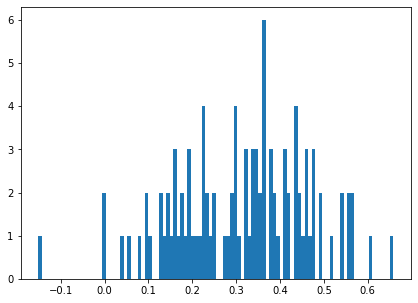

In [308]:
trend_corrs = []
value_corrs = []
# for sc_agent_id in predict_rl_states[0].keys():
va_agent_id = f'ppo_va_1_0'
for rl_states in train_rl_states:
    value_corrs = []
    for states in rl_states.values():
        gap = []
        portfolio = []

        agent_states = states['states']
        portfolio += [s['observations'][0] for s in agent_states]
        gap += [s['observations'][1] for s in agent_states]
        gap_array = np.array(gap)
        portfolio_array = np.array(portfolio)
#         gap_corr = np.corrcoef(gap_array, -portfolio_array)
#         print(gap_corr)
        value_corrs.append(scipy.stats.spearmanr(gap_array, -portfolio_array)[0])
    plt.figure(figsize = [7, 5])
plt.hist(value_corrs, bins = 100)
    

(array([5., 0., 0., 0., 0., 0., 0., 0., 0., 5.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

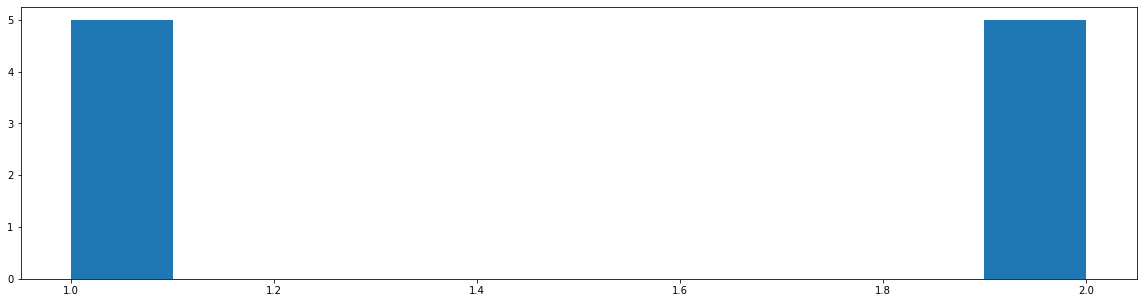

In [321]:
plt.hist([1, 1, 1, 2, 2, 2], density = True, stacked = True)

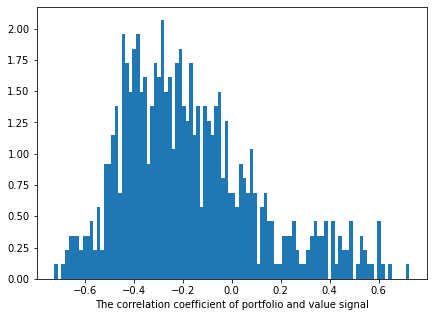

In [297]:
trend_corrs = []
total_corrs = []
# for sc_agent_id in predict_rl_states[0].keys():
va_agent_id = f'ppo_va_1_0'
for rl_states in predict_rl_states:
    value_corrs = []
    for states in rl_states.values():
        gap = []
        portfolio = []

        agent_states = states['states']
        portfolio += [s['observations'][0] for s in agent_states]
        gap += [s['observations'][1] for s in agent_states]
        gap_array = np.array(gap)
        portfolio_array = np.array(portfolio)
#         gap_corr = np.corrcoef(gap_array, -portfolio_array)
#         print(gap_corr)
        value_corrs.append(scipy.stats.spearmanr(gap_array, -portfolio_array)[0])
    total_corrs+=value_corrs
#     plt.figure(figsize = [7, 5])
#     plt.hist(value_corrs, density = True, bins = 100)
#     plt.show()

plt.figure(figsize = [7, 5])
plt.hist(total_corrs, density = True, bins = 100)
plt.xlabel('The correlation coefficient of portfolio and value signal')
plt.show()


In [295]:
trend_corrs = []
value_corrs = []
# for sc_agent_id in predict_rl_states[0].keys():
va_agent_id = f'ppo_va_1_0'
for rl_states in train_rl_states:
    gap = []
    portfolio = []

    agent_states = rl_states[va_agent_id]['states'][:1000]
    portfolio += [s['observations'][0] for s in agent_states]
    gap += [s['observations'][1] for s in agent_states]
    gap_array = np.array(gap)
    portfolio_array = np.array(portfolio)
    gap_corr = np.corrcoef(gap_array, -portfolio_array)
    print(gap_corr)
    print(scipy.stats.spearmanr(gap_array, -portfolio_array))
    

KeyError: 'ppo_va_1_0'

### Price & Value

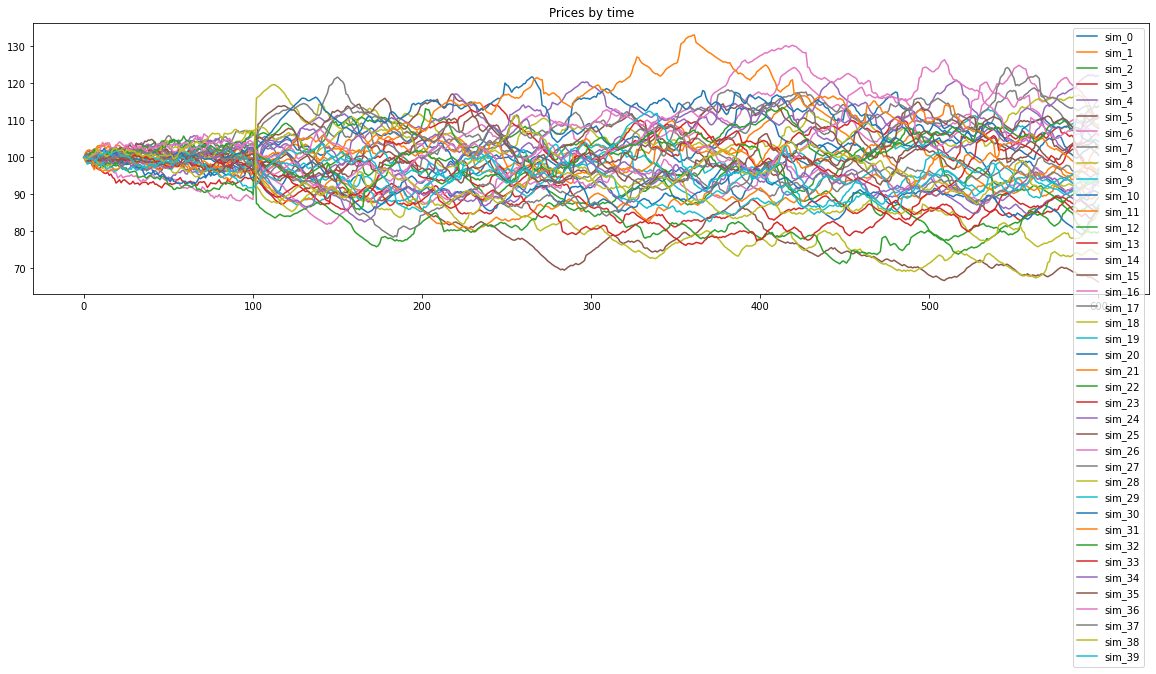

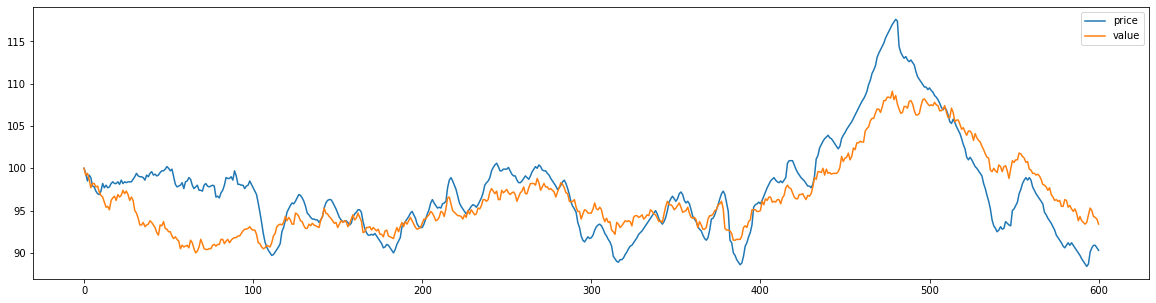

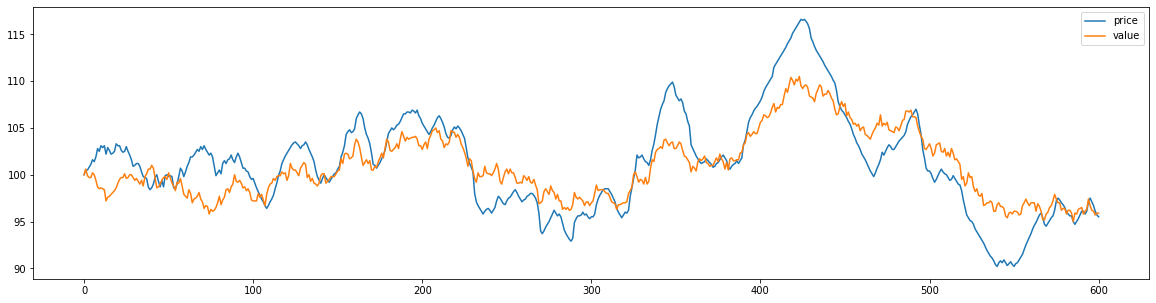

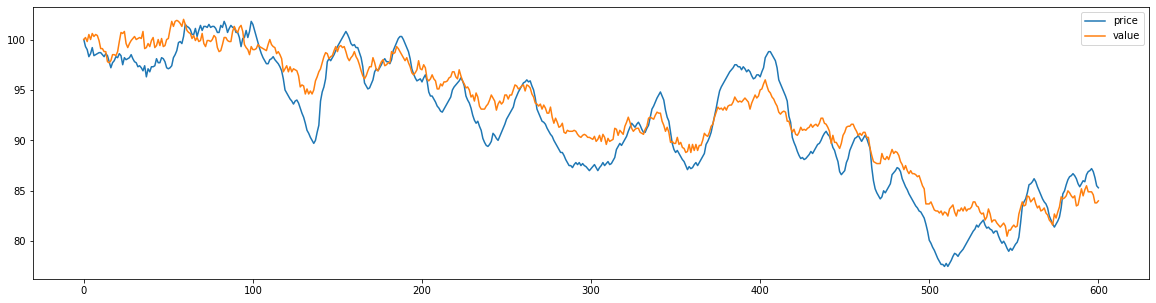

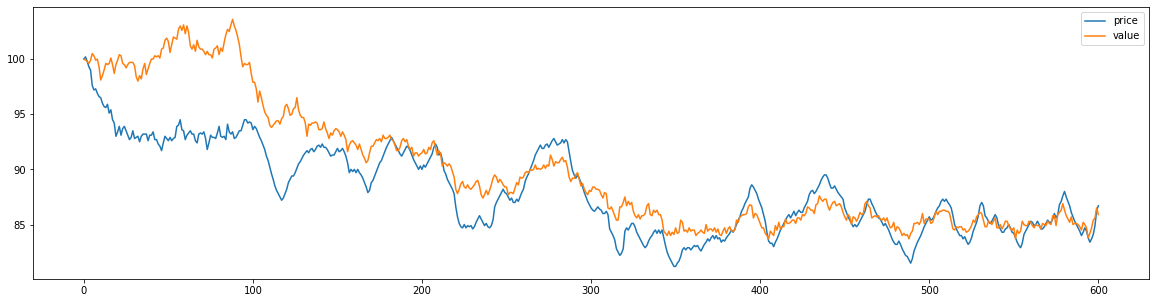

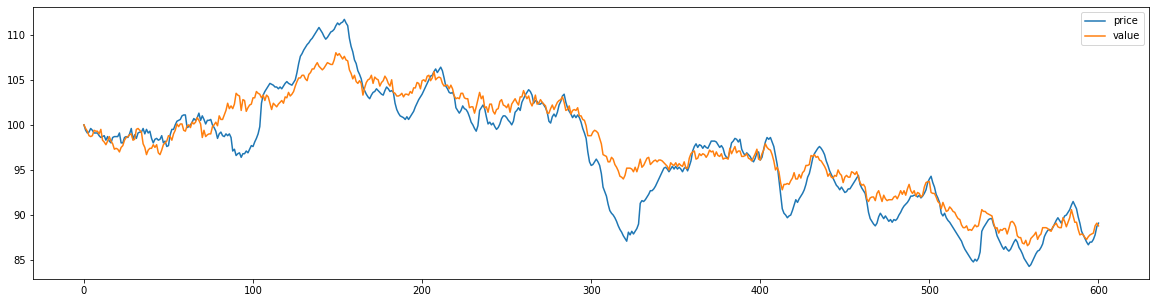

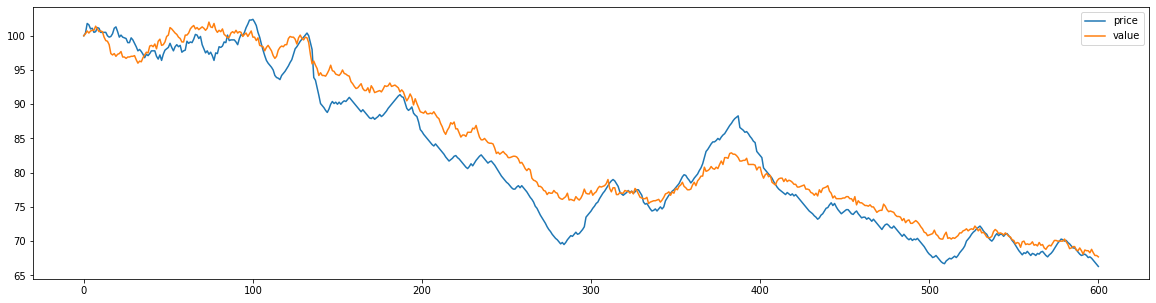

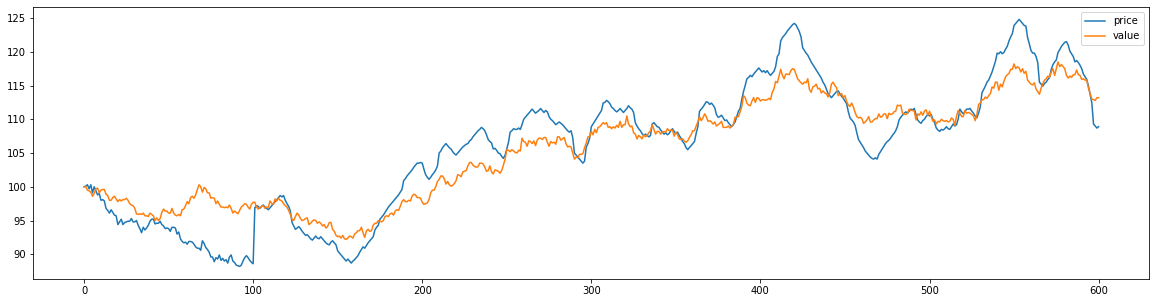

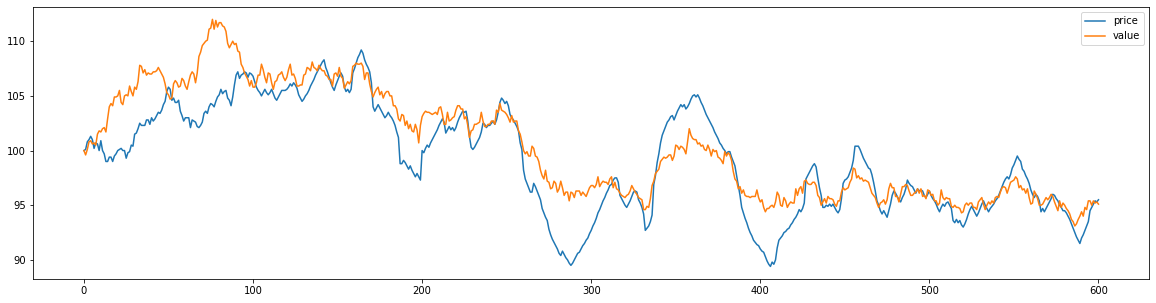

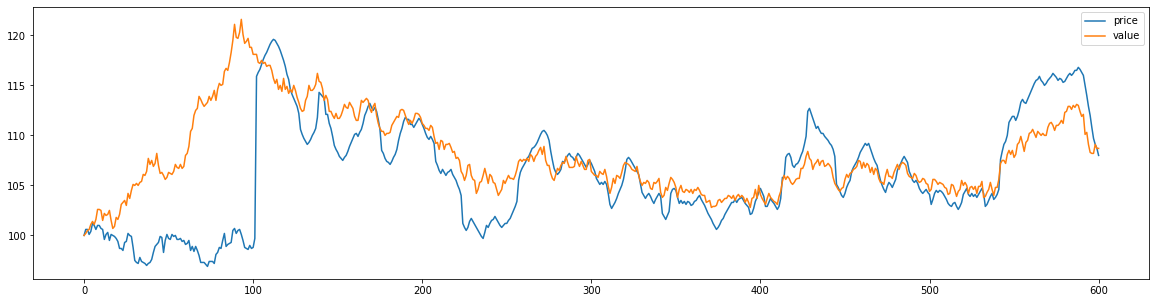

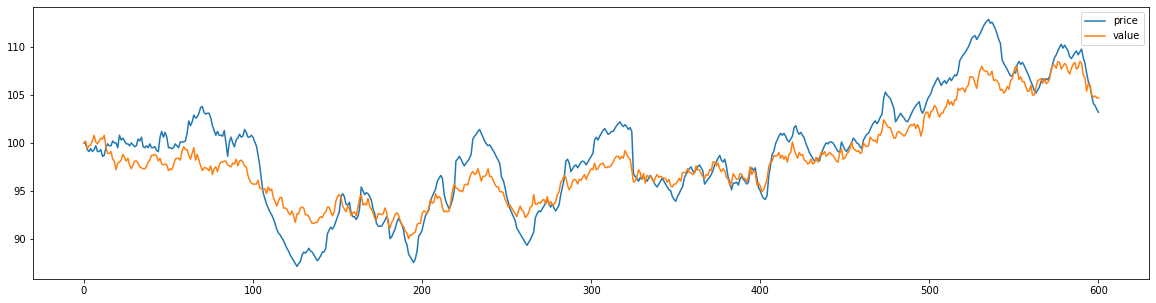

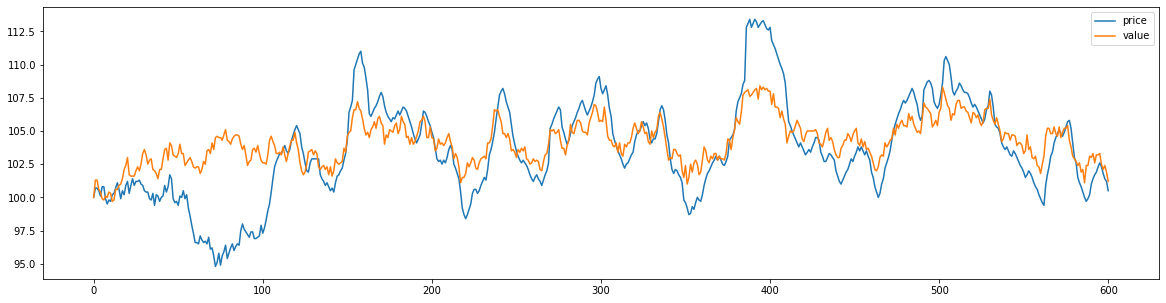

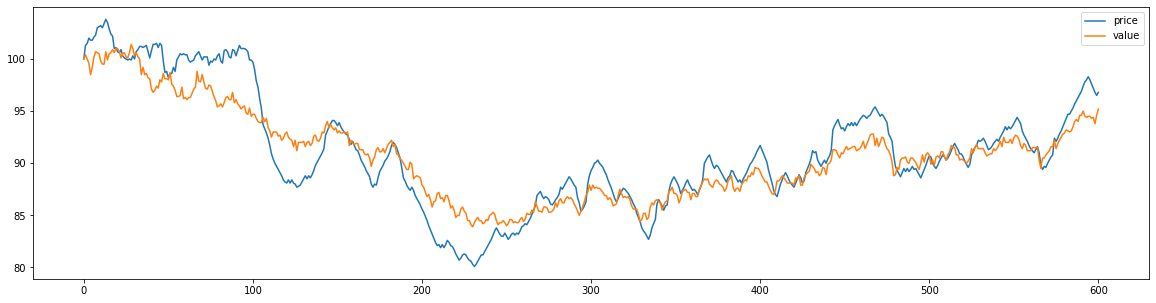

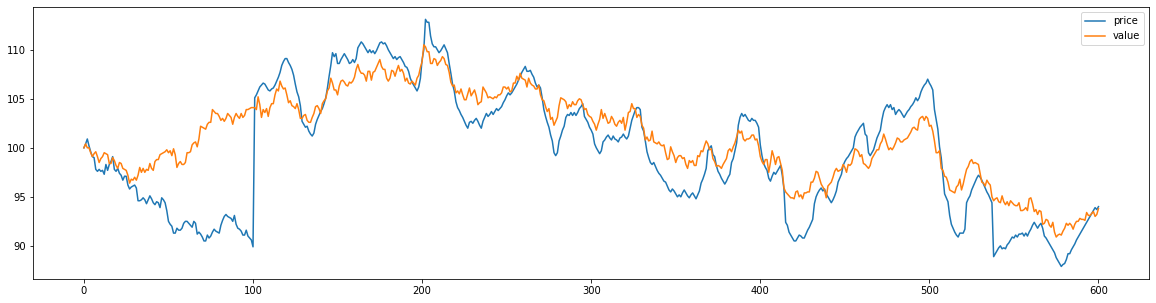

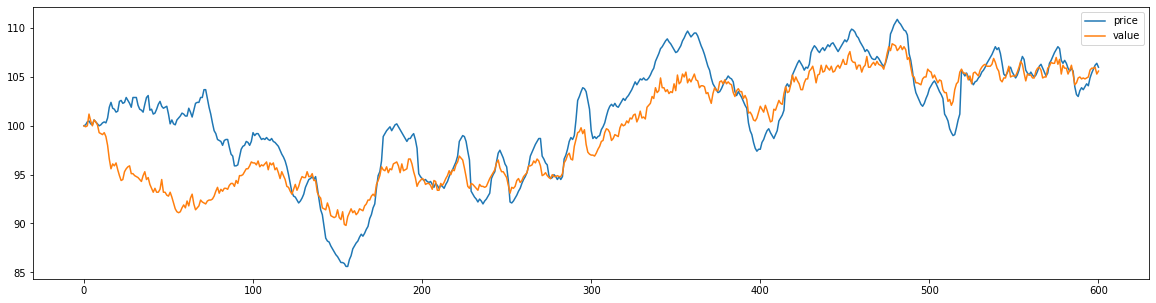

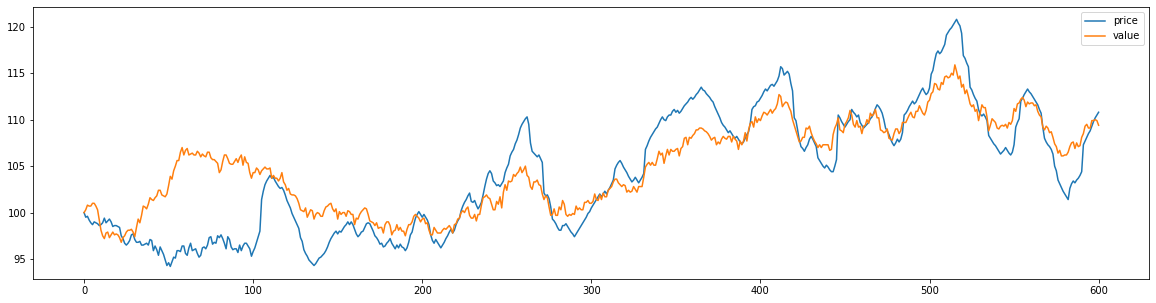

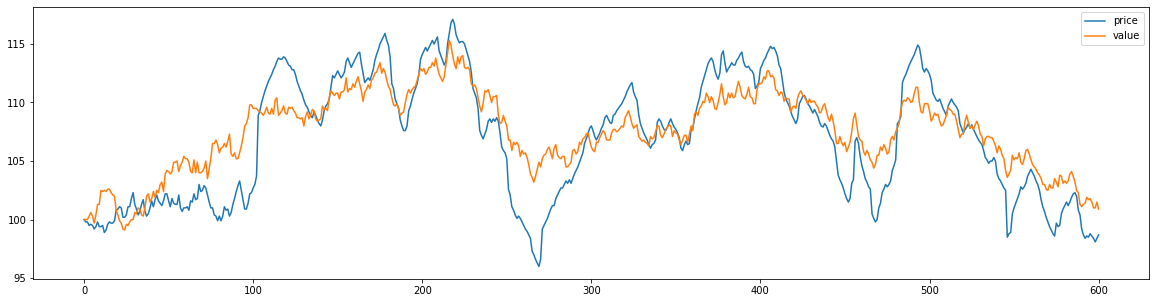

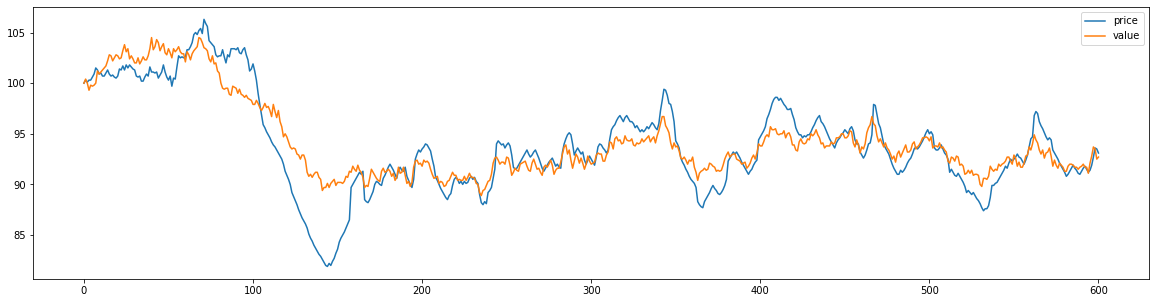

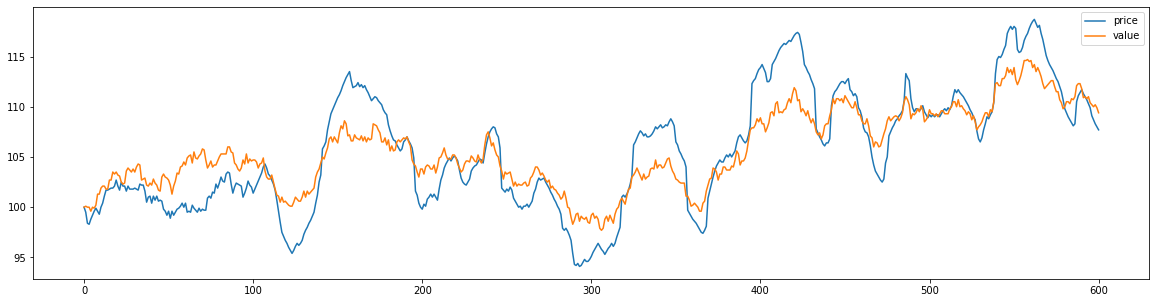

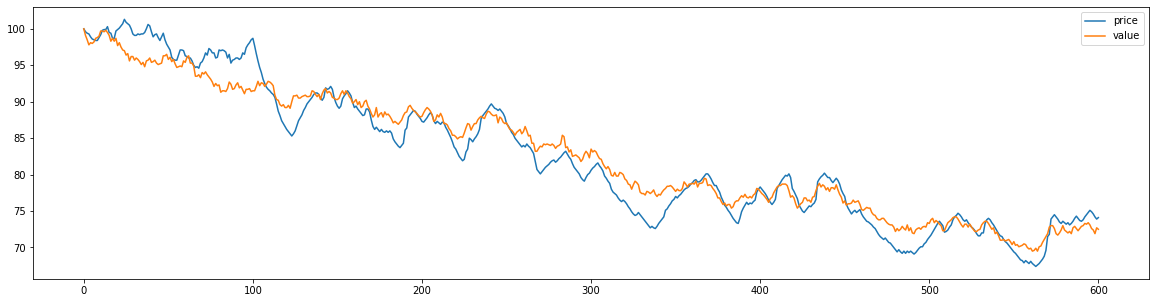

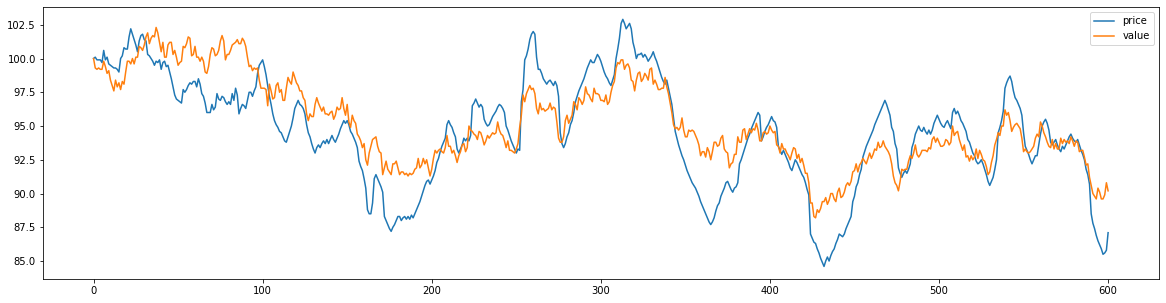

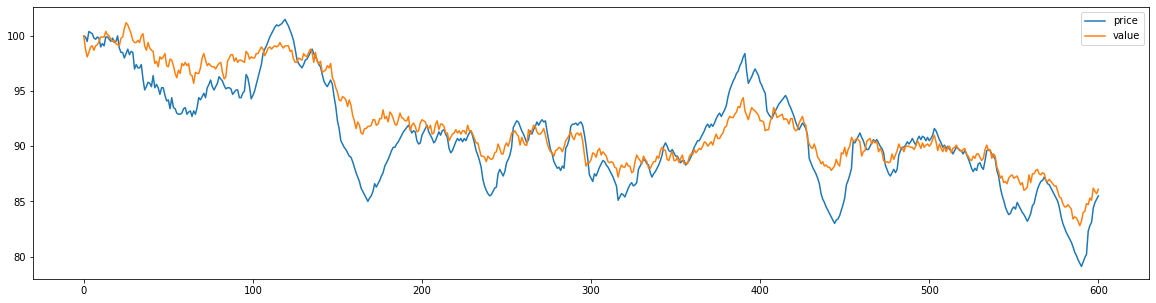

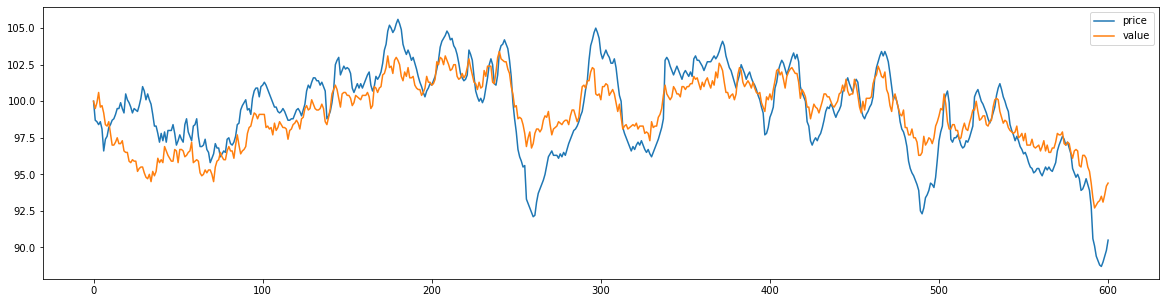

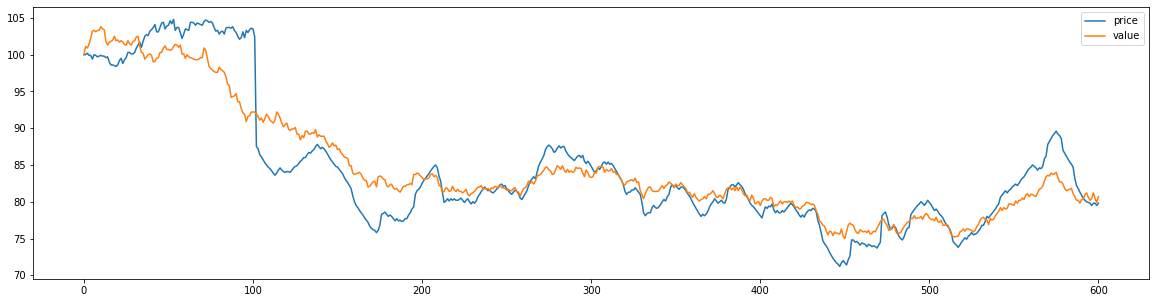

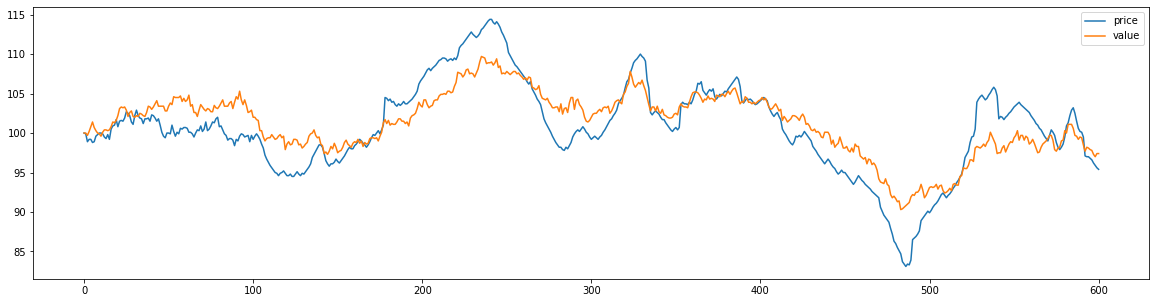

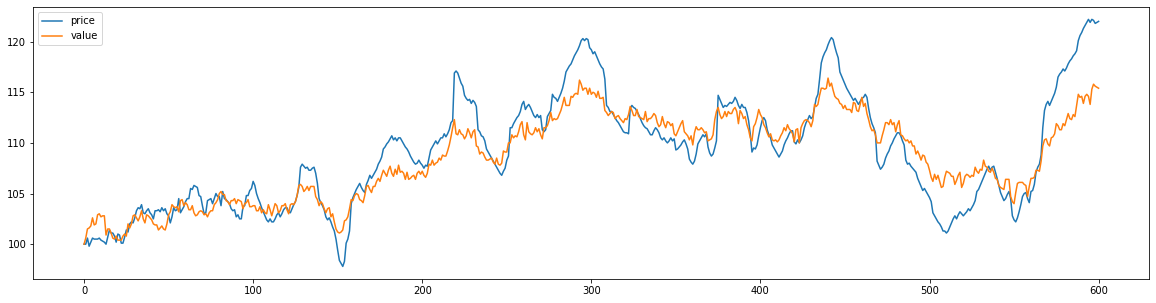

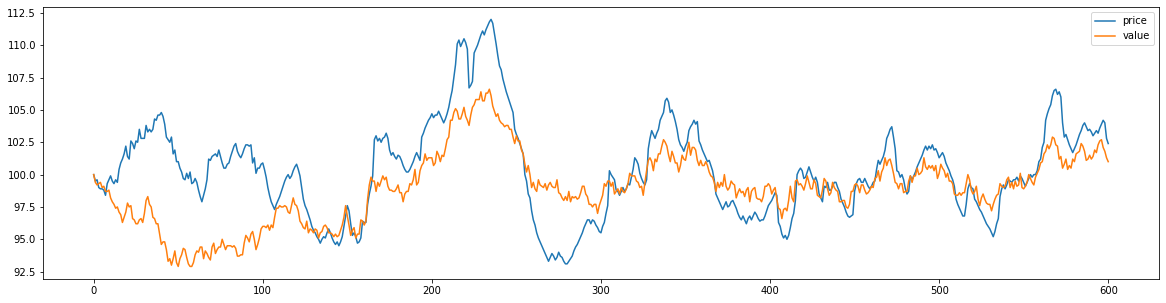

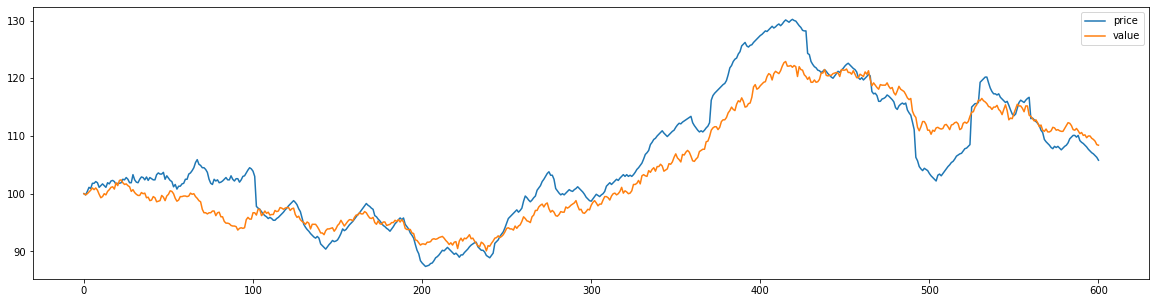

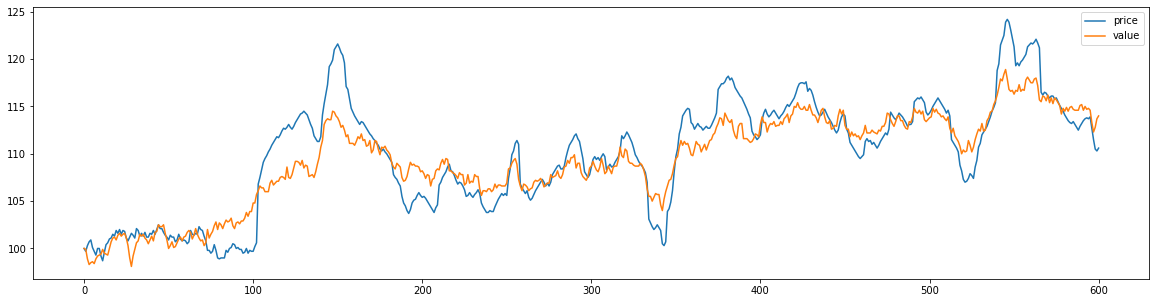

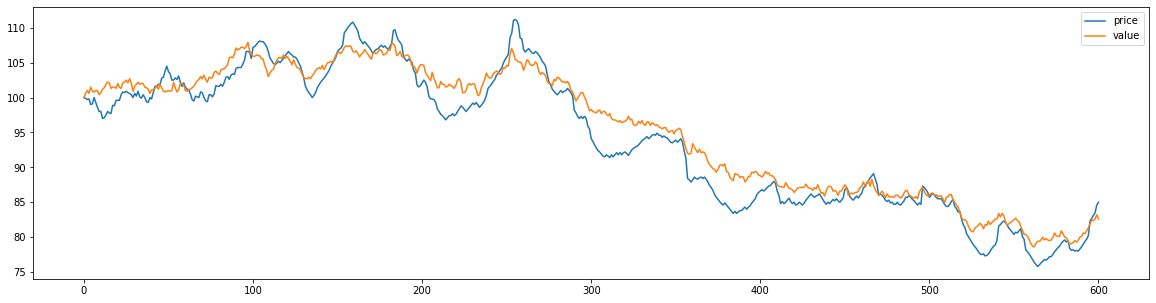

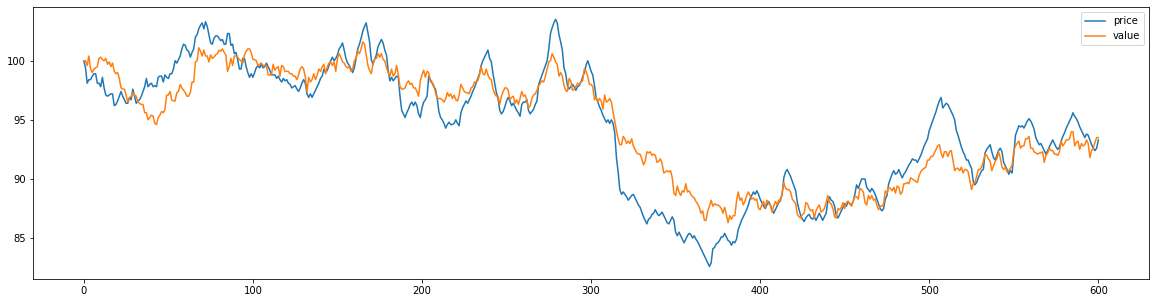

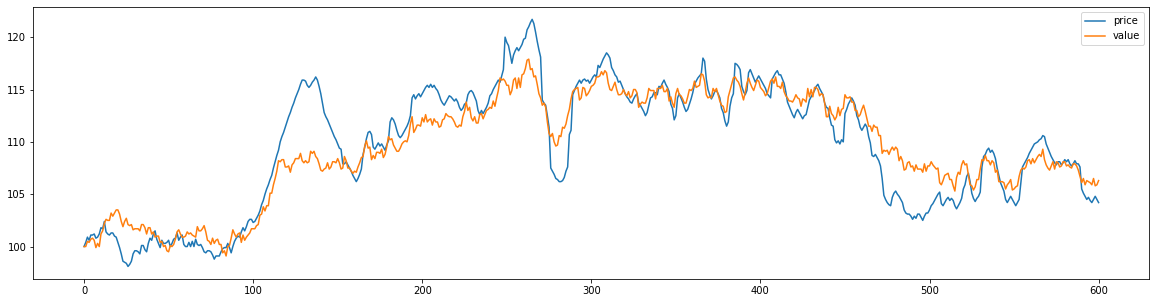

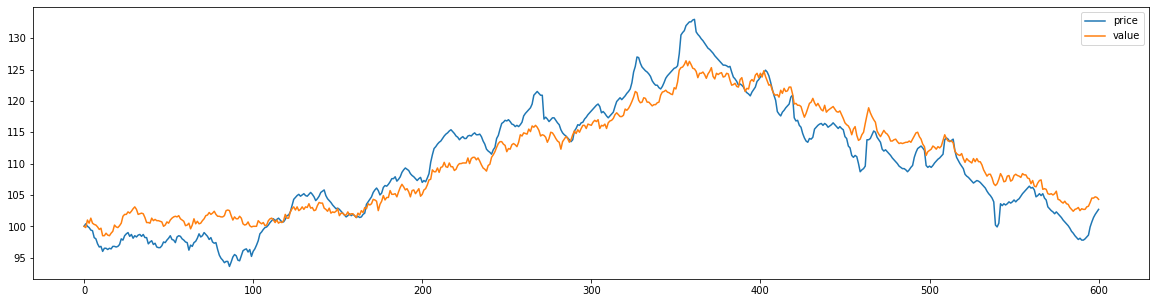

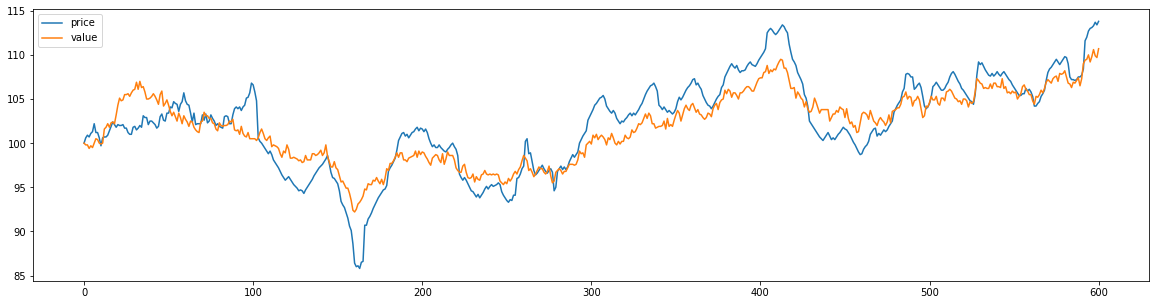

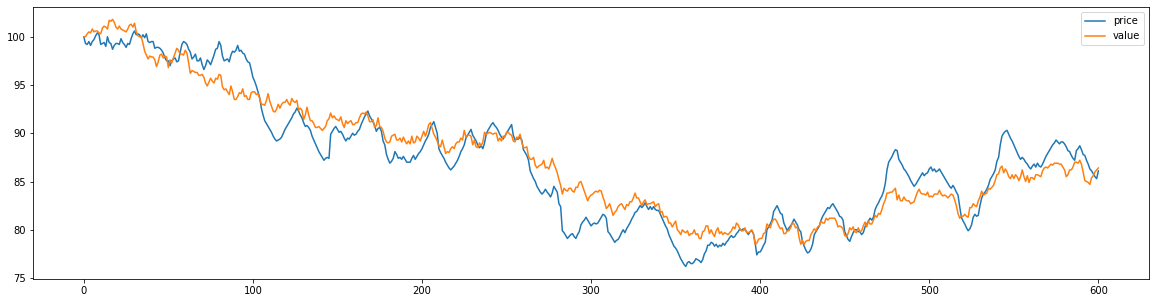

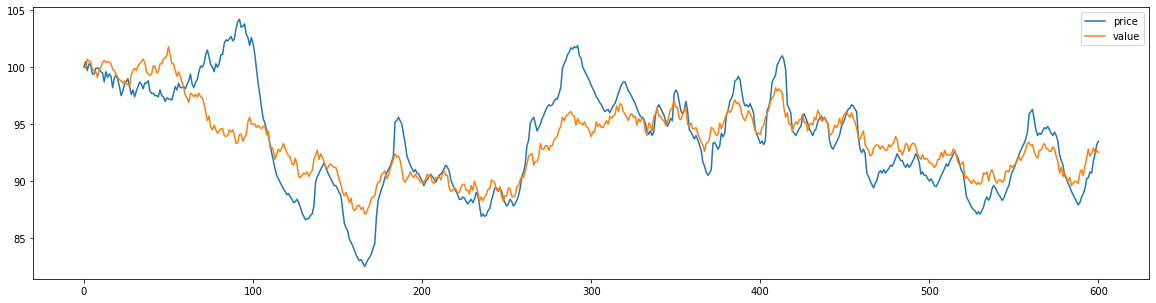

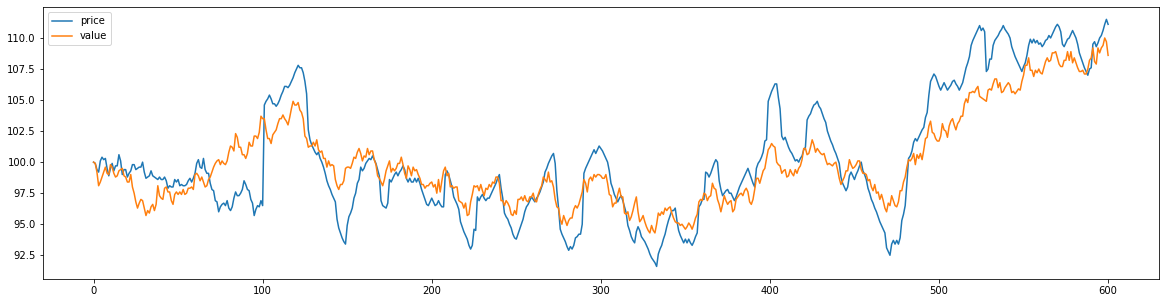

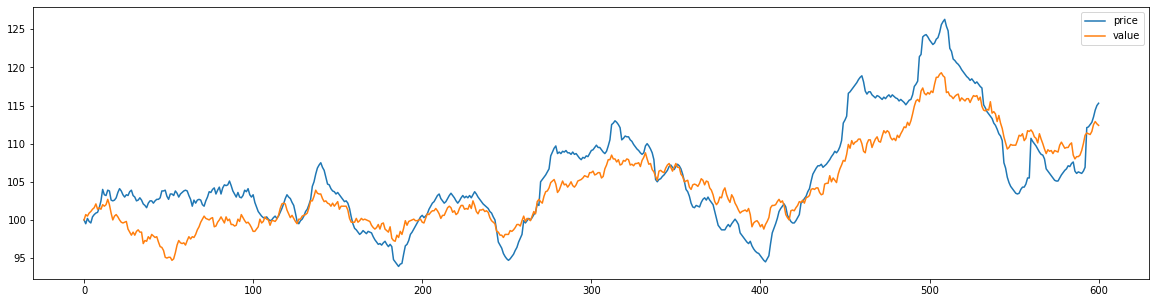

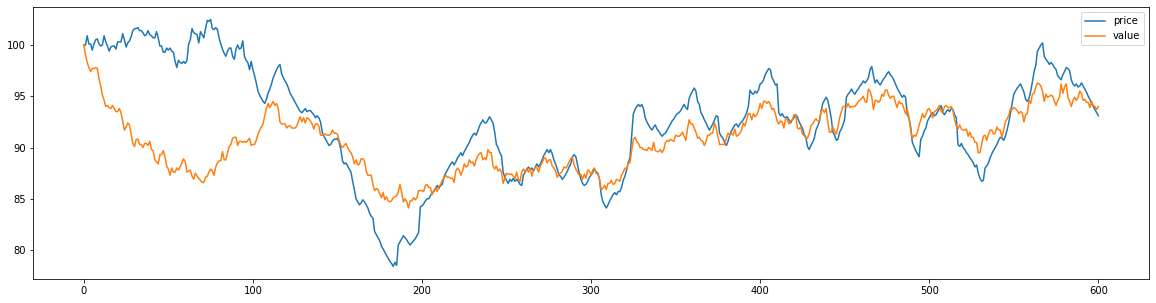

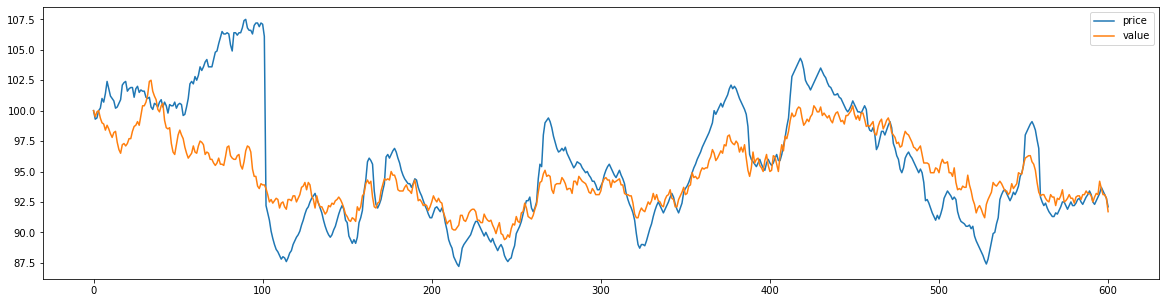

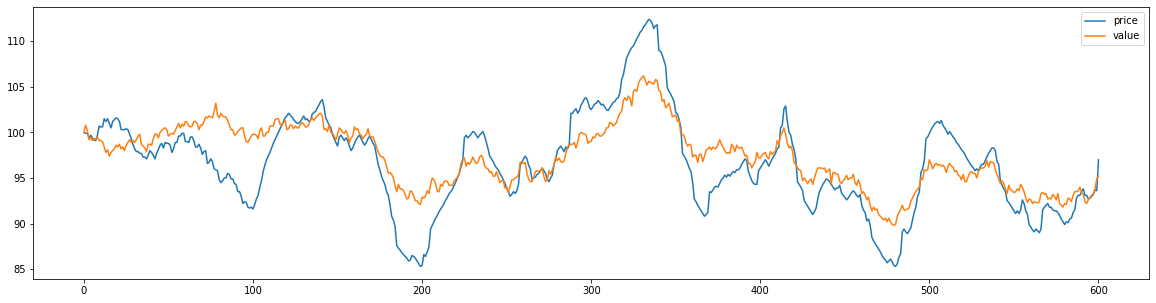

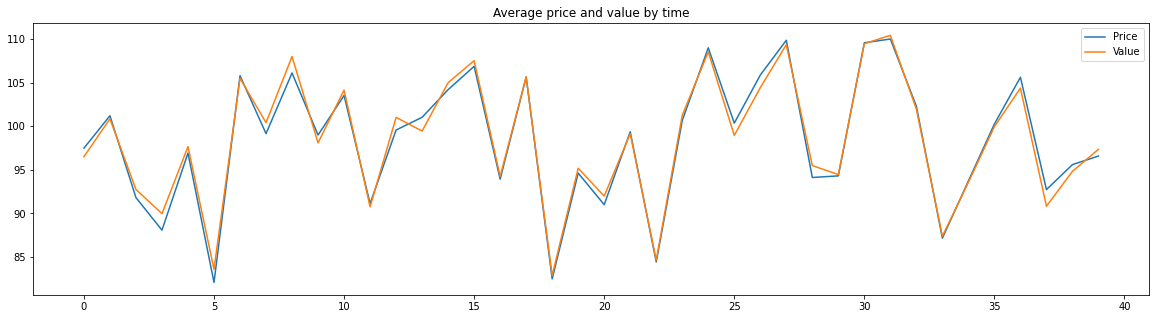

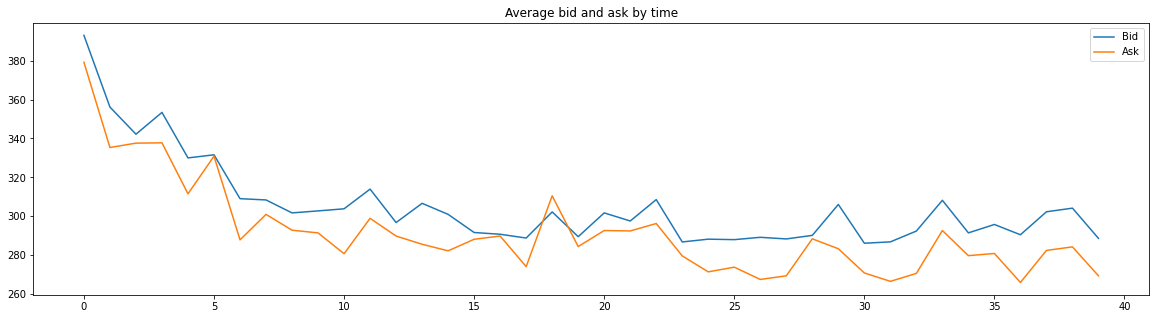

In [380]:
plot_market(train_markets)

### Agent returns

#### Distribution of total returns 

In [ ]:
plot_total_distribution_of_return(train_rl_states)

#### Distribution of returns by agent

In [ ]:
agent_returns = plot_distribution_of_return_by_agent(train_rl_states)

### Total loss

In [ ]:
plot_average_loss_by_time(train_rl_states, train_markets, agent_ids)

### Sample agent

#### Trend

In [ ]:
look_backs = config['Agent']['RLAgent'][0]['look_backs']
look_back_freq = {}
for i, look_back in enumerate(look_backs):
    total_length = 0
    bid = 0
    ask = 0
    for t in range(len(train_rl_states)):
        tr_agent_id = f"{tr_group_name}_{i}"
        for act in train_rl_states[t][tr_agent_id]['actions']:
            if act[0] == 0:
                bid += 1
            elif act[0] == 1:
                ask += 1
        total_length += len(train_rl_states[t][tr_agent_id]['actions'])

    look_back_freq[look_back] = {'bid': bid / total_length, 'ask': ask / total_length, 'act': (bid+ask) / total_length}
l = []
ar = []
for i in range(100):
    if i not in look_back_freq.keys():
        continue
    action_rate = look_back_freq[i]['act']
    l += [i]
    ar += [action_rate]
plt.scatter(l, ar)

In [ ]:
tr_agent_id = sample_agent_id(tr_group_name, tr_agent_number)

In [ ]:
plot_wealth_by_time(train_rl_states, tr_agent_id)

In [ ]:
plot_holdings(train_rl_states, tr_agent_id)

In [ ]:
plot_loss(train_rl_states, tr_agent_id)

In [ ]:
plot_reward_by_time(train_rl_states, tr_agent_id)

In [ ]:
plot_obs_action_reward(train_rl_states, tr_agent_id, ['prop', 'dp'])

In [ ]:
plot_action_with_reward(train_rl_states, train_markets, tr_agent_id)

#### Value

In [ ]:
va_agent_id = sample_agent_id(va_group_name, va_agent_number)

In [ ]:
plot_wealth_by_time(train_rl_states, va_agent_id)

In [166]:
total_returns = sum([agents['returns_by_agent']  for agents in group_agent.values()], list())
real_returns = np.array(total_returns) - (pow(1.0004, timesteps) - 1)
data = real_returns
mean, var  = scipy.stats.distributions.norm.fit(data)
x = np.linspace(min(data), max(data),100)
fitted_data = scipy.stats.distributions.norm.pdf(x, mean, var)
plt.figure(figsize = (5, 5))
plt.title(f'Fit result: mu={round(mean, 2)}, sigma={round(var, 2)}')
plt.hist(data, bins=100, alpha = 1, density=True)
plt.plot(x, fitted_data,'r-')

NameError: name 'group_agent' is not defined

In [ ]:
plot_holdings(train_rl_states, va_agent_id)

In [ ]:
plot_loss(train_rl_states, va_agent_id)

In [ ]:
plot_reward_by_time(train_rl_states, va_agent_id)

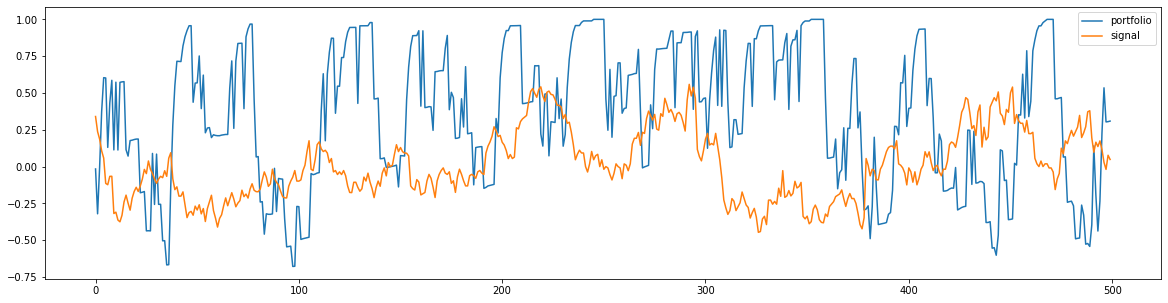

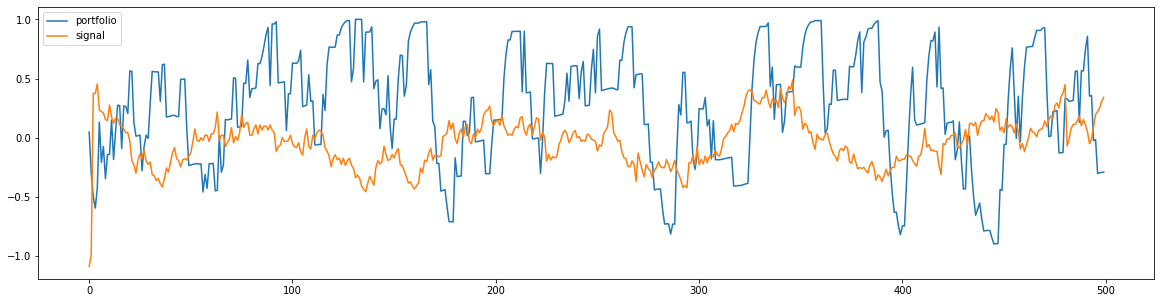

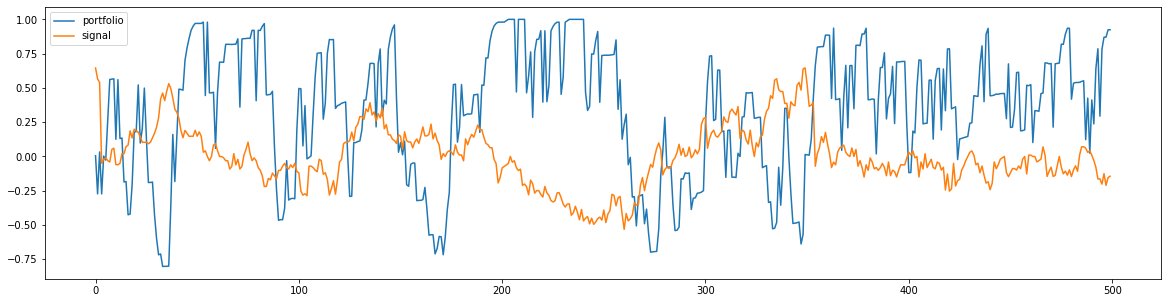

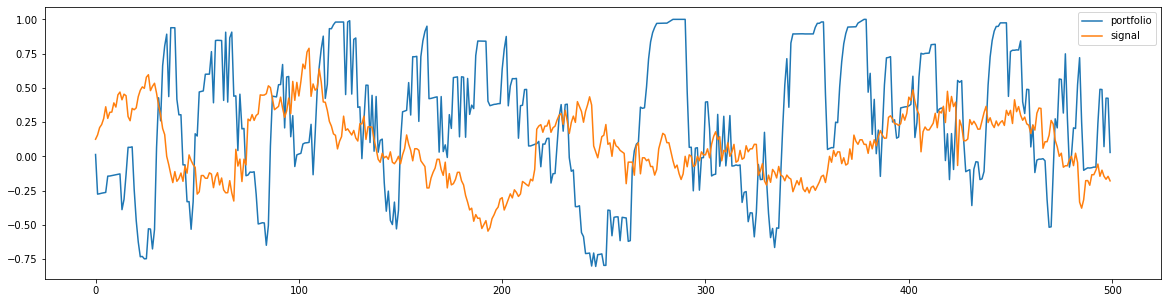

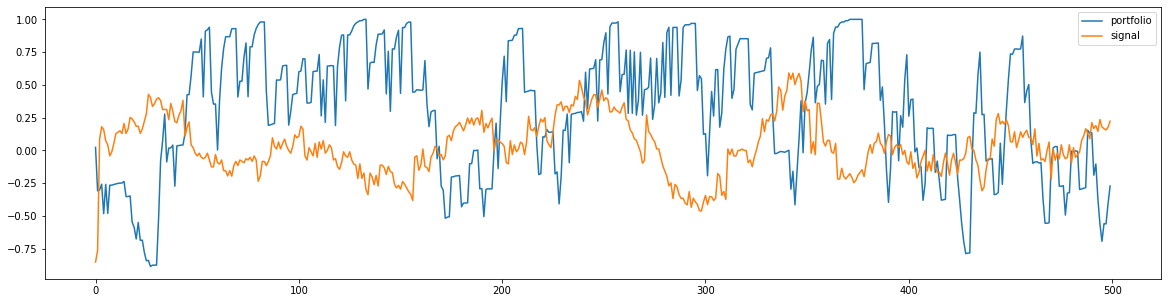

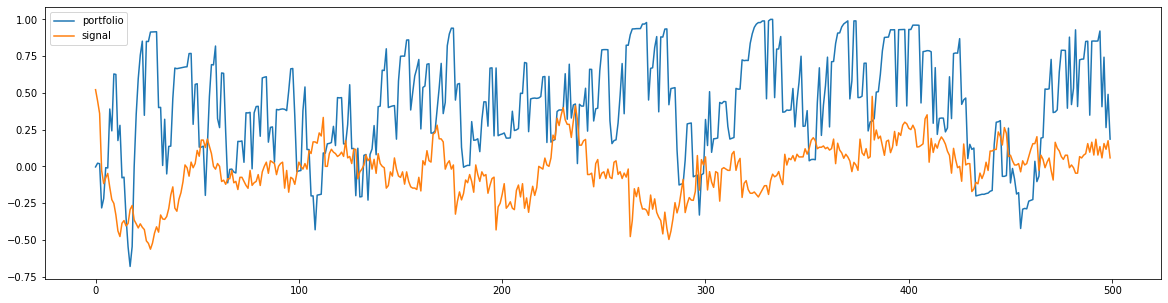

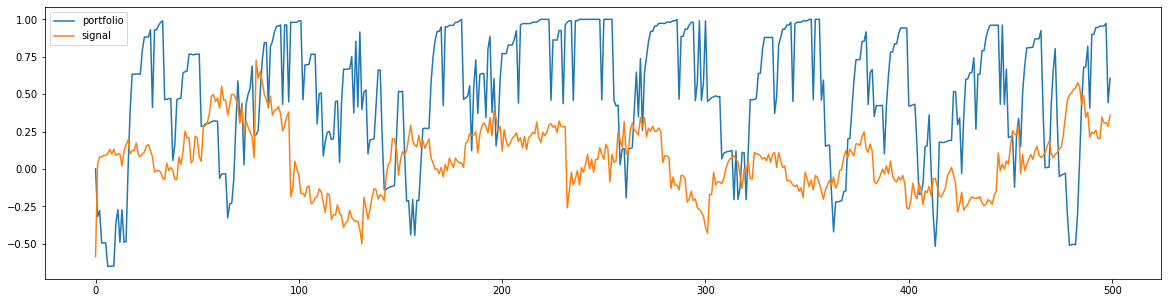

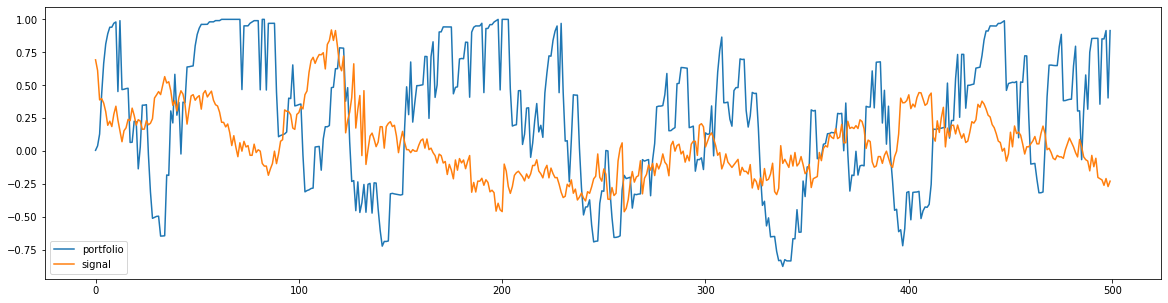

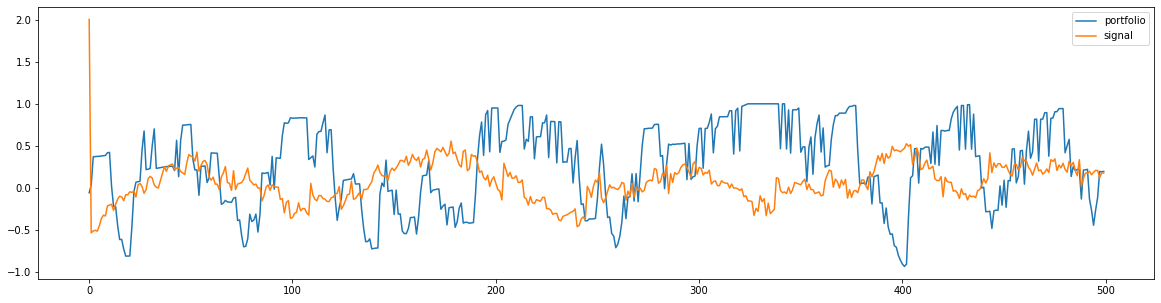

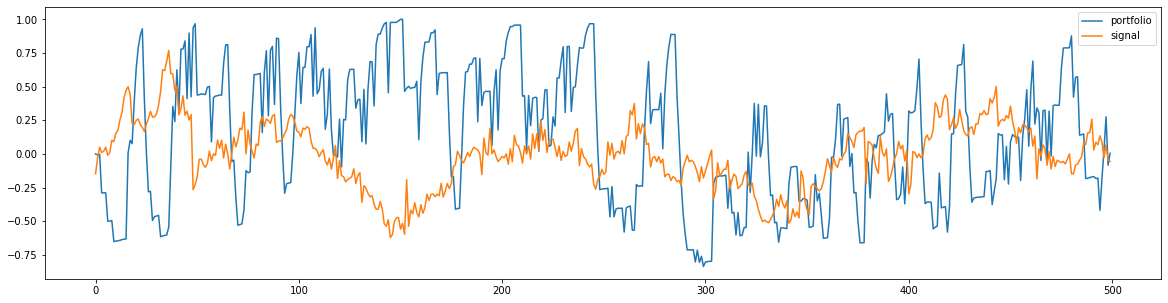

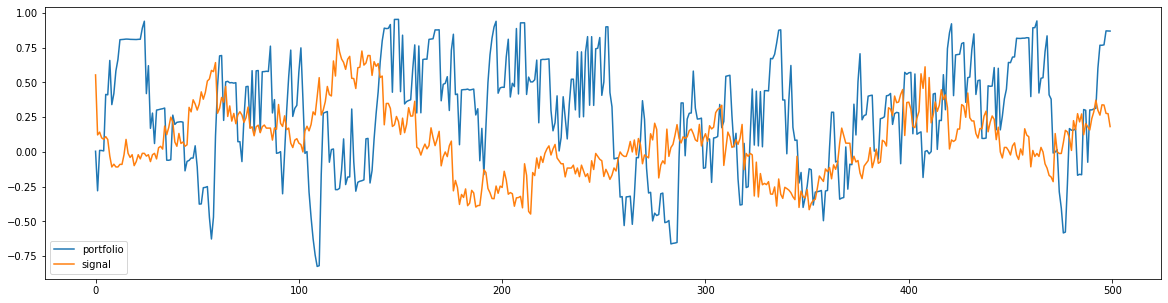

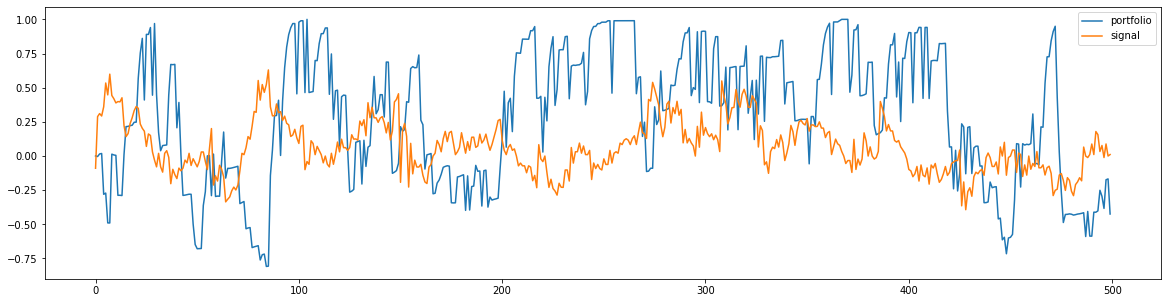

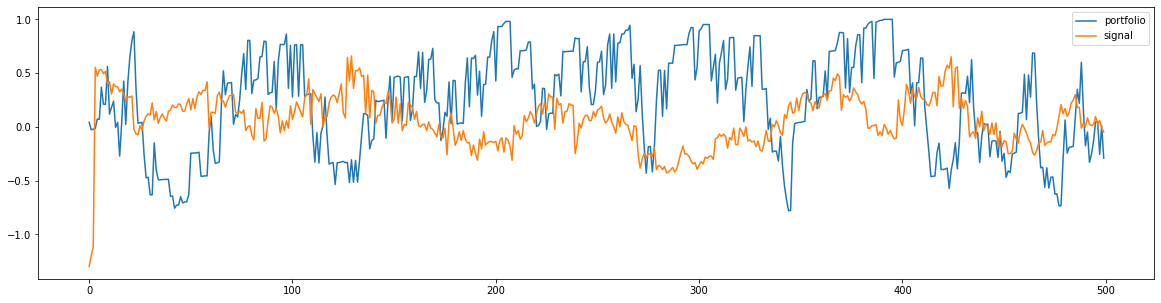

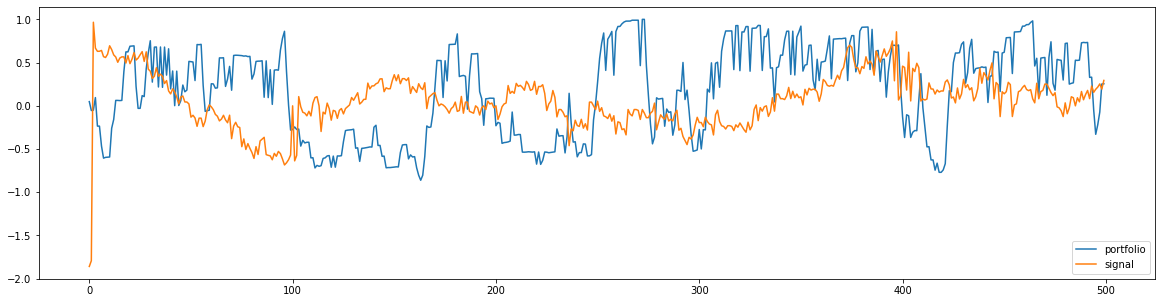

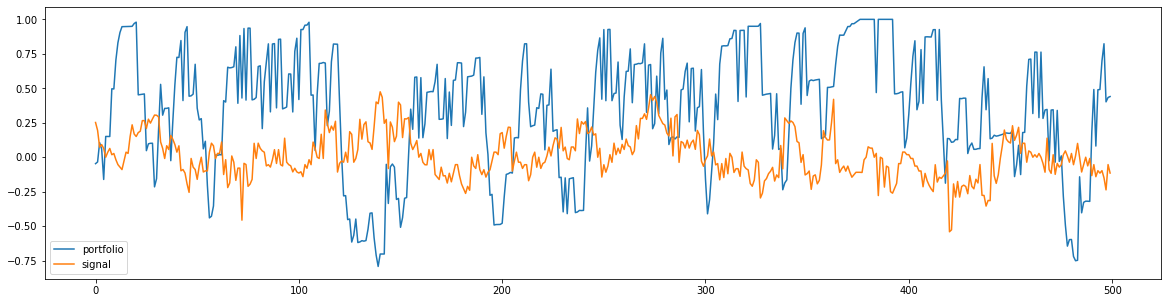

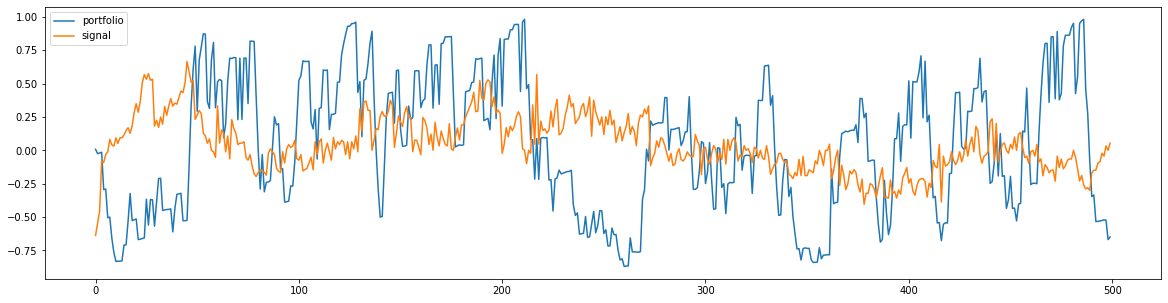

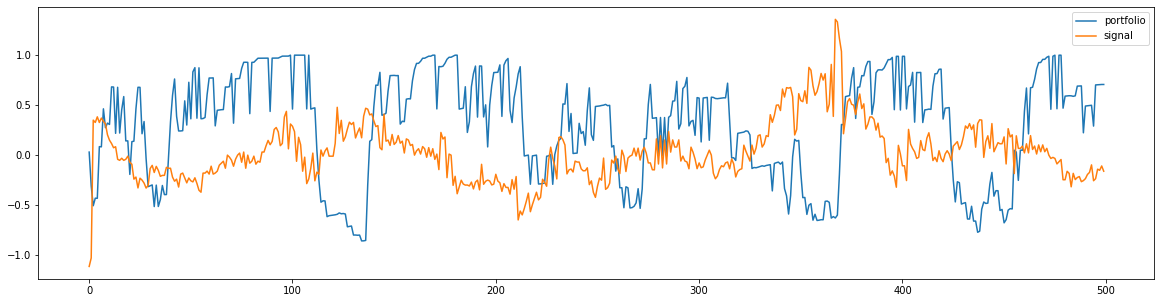

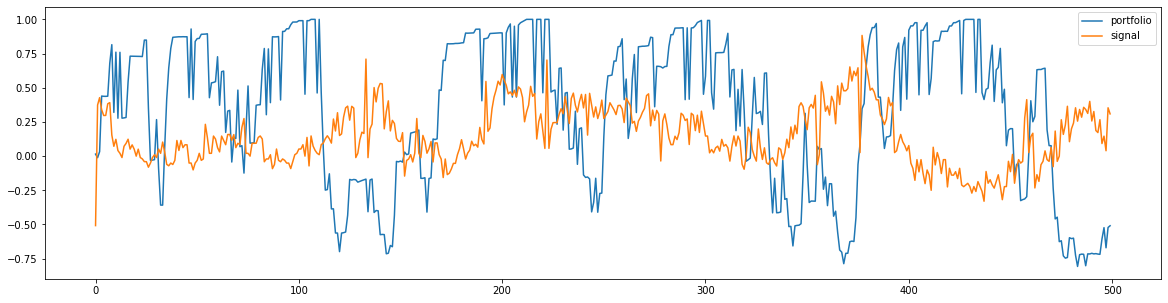

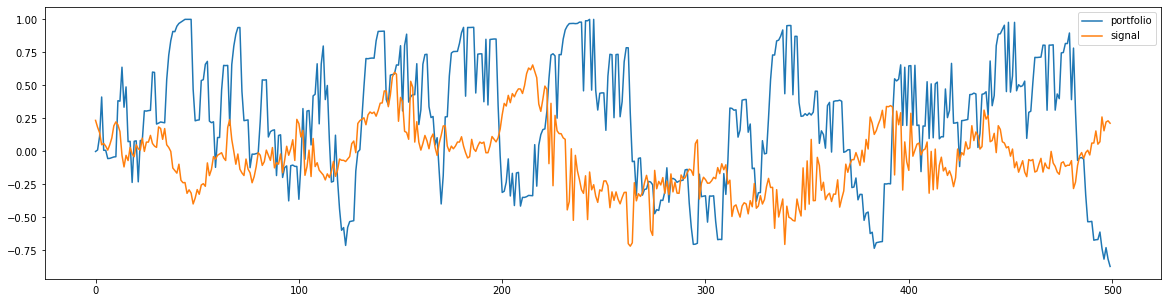

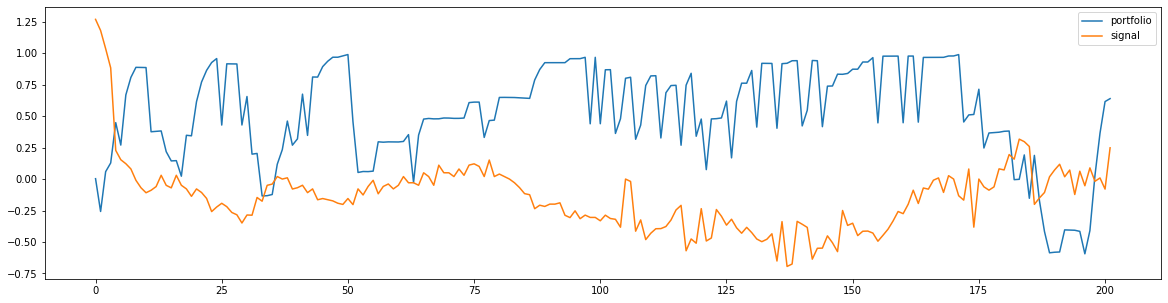

In [202]:
plot_obs_action_reward(train_rl_states, va_agent_id, ['portfolio', 'signal'])

In [ ]:
plot_action_with_reward(train_rl_states, train_markets, va_agent_id)

#### Scaling

In [ ]:
sc_agent_id = sample_agent_id(sc_group_name, sc_agent_number)

In [ ]:
plot_wealth_by_time(train_rl_states, sc_agent_id)

In [ ]:
plot_holdings(train_rl_states, sc_agent_id)

In [ ]:
plot_loss(train_rl_states, sc_agent_id)

In [ ]:
plot_reward_by_time(train_rl_states, sc_agent_id)

In [ ]:
plot_obs_action_reward(train_rl_states, sc_agent_id, ['prop', 'noise', 'fund'])

In [ ]:
plot_action_with_reward(train_rl_states, train_markets, sc_agent_id)

In [ ]:
for rl_state in train_rl_states:
    for i, item in enumerate(['opt_utility', 'pes_utility', 'fud_utility']):
        max_obs = [state['observations'].index(max(state['observations'])) for state in rl_state[sc_agent_id]['states']]
        
        plt.plot(l, label = item)
    plt.legend()
    plt.show()


## Validate

In [ ]:
validate_dir_path = record_path / 'validate'
validate_markets, validate_agents, validate_rl_states, validate_lengths, validate_timesteps = get_plot_data(validate_dir_path, 0, 20)

### Price & Value

In [ ]:
plot_market(validate_markets)

### Agent returns

#### Distribution of total returns 

In [ ]:
plot_total_distribution_of_return(validate_rl_states)

#### Distribution of returns by agent

In [ ]:
plot_distribution_of_return_by_agent(validate_rl_states)

### Sample agent

#### Trend

In [ ]:
tr_agent_id = sample_agent_id(tr_group_name, tr_agent_number)

In [ ]:
plot_wealth_by_time(validate_rl_states, tr_agent_id)

In [ ]:
plot_holdings(validate_rl_states, tr_agent_id)

In [ ]:
plot_action(validate_rl_states, validate_markets, tr_agent_id)

#### Value

In [14]:
va_agent_id = sample_agent_id(va_group_name, va_agent_number)

In [ ]:
plot_wealth_by_time(validate_rl_states, va_agent_id)

In [ ]:
plot_holdings(validate_rl_states, va_agent_id)

In [13]:
plot_obs_action(validate_rl_states, va_agent_id, ['prop', 'gap'])

NameError: name 'validate_rl_states' is not defined

In [ ]:
plot_action(validate_rl_states, validate_markets, va_agent_id)

#### Scaling

In [ ]:
sc_agent_id = sample_agent_id(sc_group_name, sc_agent_number)

In [ ]:
plot_wealth_by_time(validate_rl_states, sc_agent_id)

In [ ]:
plot_holdings(validate_rl_states, sc_agent_id)

In [ ]:
plot_action_with_reward(validate_rl_states, validate_markets, sc_agent_id)

In [ ]:
cal_sc_good_action(validate_rl_states, validate_markets, sc_agent_id)

In [268]:
for rl_state in validate_rl_states:
    for i, item in enumerate(['opt_utility', 'pes_utility', 'fud_utility']):
        l = [state['observations'][i] for state in rl_state[sc_agent_id]['states']]
        plt.plot(l, label = item)
    plt.legend()
    plt.show()


NameError: name 'validate_rl_states' is not defined

## Predict

In [377]:
predict_dir_path = record_path / 'predict'
predict_markets, predict_agents, predict_rl_states, predict_lengths, predict_timesteps = get_plot_data(predict_dir_path)

Simulation times: 3
Average training length: 1351.0


### Correlations

In [376]:
trend_corrs = []
value_corrs = []
# for sc_agent_id in predict_rl_states[0].keys():
va_agent_id = f'ppo_va_1_0'
for rl_states in predict_rl_states:
    gap = []
    portfolio = []

    agent_states = rl_states[va_agent_id]['states'][:1000]
    portfolio += [s['observations'][0] for s in agent_states]
    gap += [s['observations'][1] for s in agent_states]
    gap_array = np.array(gap)
    portfolio_array = np.array(portfolio)
    gap_corr = np.corrcoef(gap_array, -portfolio_array)
    print(gap_corr)
    print(scipy.stats.spearmanr(gap_array, -portfolio_array))
    

KeyError: 'ppo_va_1_0'

In [ ]:
config['Agent']['RLAgent'][0]['look_backs']
for sc_agent_id in predict_rl_states[0].keys():
    portfolio = []
    for rl_states in predict_rl_states:
        agent_states = rl_states[sc_agent_id]['states']
        portfolio += [s['observations'][0] for s in agent_states]
        trend += [s['observations'][1] for s in agent_states]
        value += [s['observations'][2] for s in agent_states]
    trend_array = np.array(trend)
    value_array = np.array(value)
    portfolio_array = np.array(portfolio)
    risk_prop = (1 - portfolio_array) / 2


### Price & Value

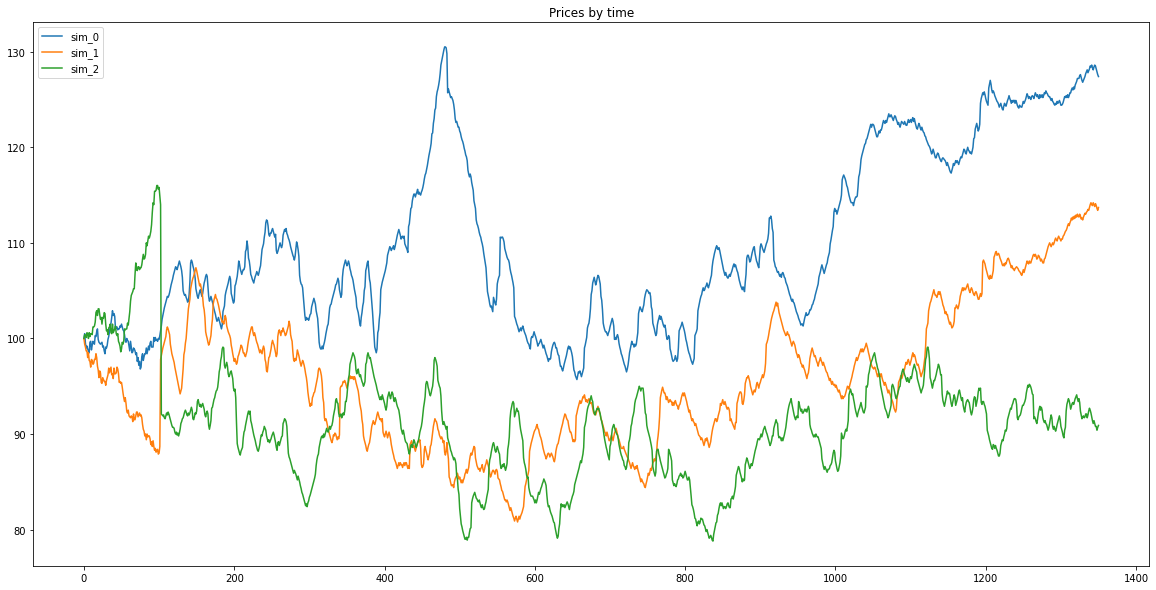

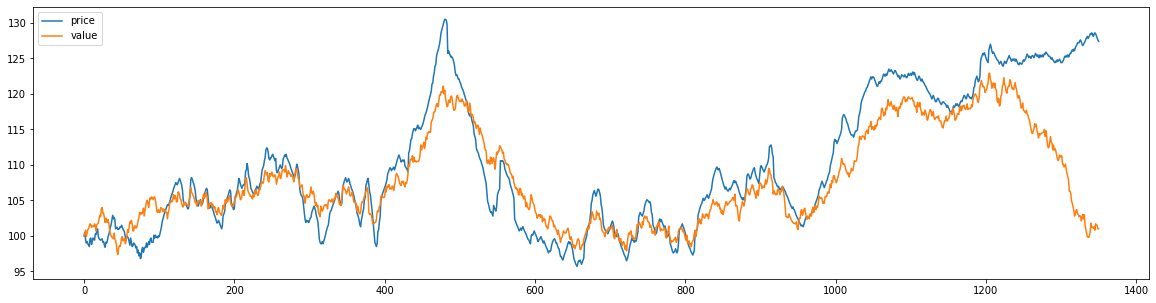

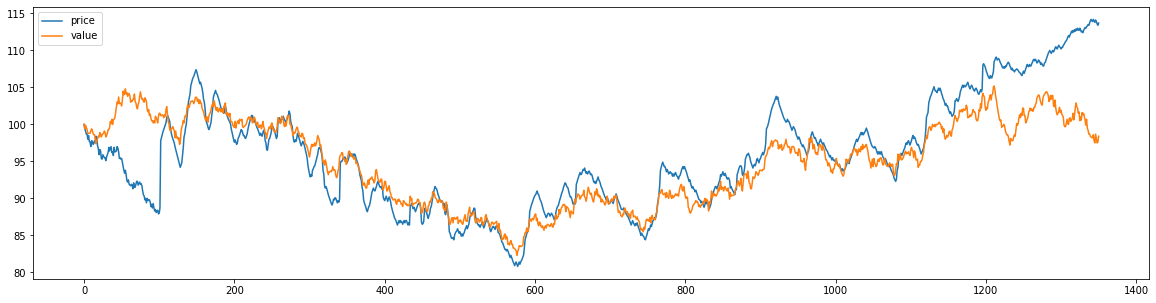

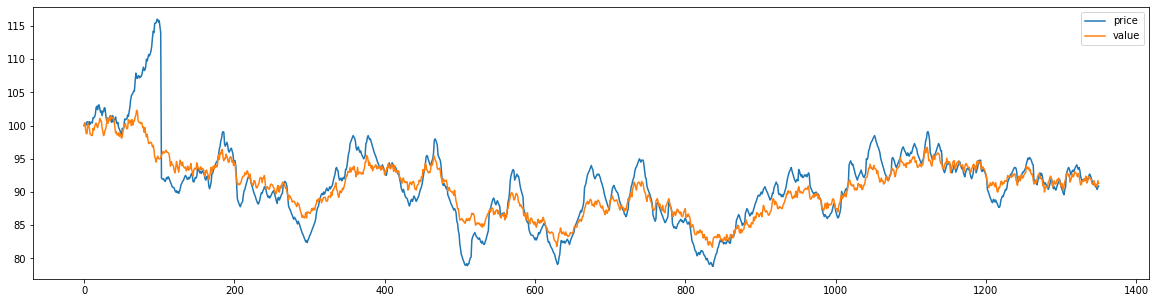

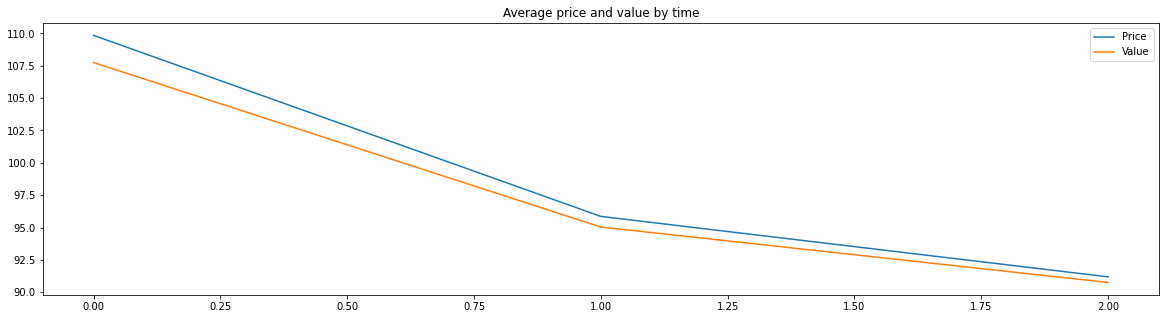

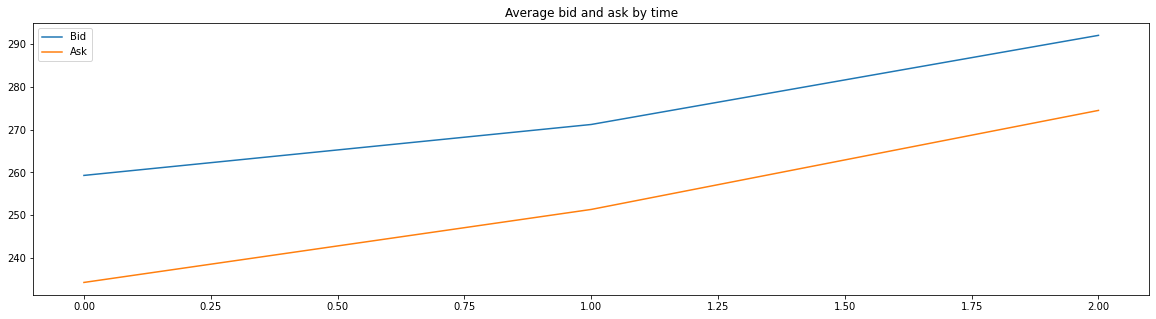

In [378]:
plt.figure(figsize = (20, 10))
plot_market(predict_markets)

### Agent returns

#### Distribution of total returns 

In [ ]:
plot_total_distribution_of_return(predict_rl_states)

#### Distribution of returns by agent

In [ ]:
plot_distribution_of_return_by_agent(predict_rl_states)

### Sample agent

#### Trend

In [ ]:
look_backs = config['Agent']['RLAgent'][0]['look_backs']
look_back_freq = {}
for i, look_back in enumerate(look_backs):
    total_length = 0
    bid = 0
    ask = 0
    for t in range(len(predict_rl_states)):
        tr_agent_id = f"{tr_group_name}_{i}"
        for act in predict_rl_states[t][tr_agent_id]['actions']:
            if act[0] == 0:
                bid += 1
            elif act[0] == 1:
                ask += 1
        total_length += len(predict_rl_states[t][tr_agent_id]['actions'])

    look_back_freq[look_back] = {'bid': bid / total_length, 'ask': ask / total_length, 'act': (bid+ask) / total_length}
l = []
ar = []
for i in range(100):
    if i not in look_back_freq.keys():
        continue
    action_rate = look_back_freq[i]['act']
    l += [i]
    ar += [action_rate]
plt.scatter(l, ar)

In [ ]:
tr_agent_id = sample_agent_id(tr_group_name, tr_agent_number)

In [ ]:
plot_wealth_by_time(predict_rl_states, tr_agent_id)

In [ ]:
plot_holdings(predict_rl_states, tr_agent_id)

In [ ]:
plot_obs_action(predict_rl_states, tr_agent_id, ['prop', 'gap'])

In [ ]:
plot_action(predict_rl_states, predict_markets, tr_agent_id)

In [ ]:
rl_states = predict_rl_states
markets = predict_markets
agent_id = tr_agent_id
# sample agent to analyse
action_ref = {0: "BID", 1: "ASK", 2: "HOLD"}
tick_ref = {i: tick for i, tick in zip(list(range(0, 9)), list(range(-4, 5)))}
print(agent_id)
for state, market in zip(rl_states, markets):
    orders = []
    counter = {"BID": 0, "ASK": 0, "HOLD": 0}
    for i, action in enumerate(state[agent_id]['actions']):
        bid_or_ask = action_ref[action[0]]
        ticks = 1
        price = market['price'][99+i] + tick_size * ticks
        volume = 1
        order = {'time': i, "bid_or_ask": bid_or_ask, "price": price, "volume": volume}
        counter[bid_or_ask] += 1
        orders.append(order)

    total_actions = sum(counter.values())
    print(counter)
    print(f"Bid: {counter['BID'] / total_actions}\nAsk: {counter['ASK'] / total_actions}\nHold: {counter['HOLD'] / total_actions}")
    bid_x, bid_y = [], []
    ask_x, ask_y = [], []
    bid_sizes, ask_sizes = [], []
    bid_colors, ask_colors = [], []
    base_size = 500
    for i, order in enumerate(orders):
        if order['bid_or_ask'] == 'BID':
    #         if order['time'] > 5000 and order['time'] < 5100:
            bid_x.append(order['time'])
            bid_y.append(order['price'])
            bid_colors.append('r')
            bid_sizes.append(base_size * order['volume'])
        if order['bid_or_ask'] == 'ASK':
    #         if order['time'] > 5000 and order['time'] < 5100:
            ask_x.append(order['time'])
            ask_y.append(order['price'])
            ask_colors.append('g')  
            ask_sizes.append(base_size * order['volume'])
    plot_price = market['price'][100:]
    plot_value = market['value'][100:]
    x = np.arange(len(plot_price))
    plt.figure(figsize=(80, 20))
    plt.plot(x, plot_price, label = "price")
    plt.plot(x, plot_value, label = "value")
    plt.legend()
    plt.scatter(bid_x, bid_y, s = bid_sizes, c = bid_colors, marker = 6)
    plt.scatter(ask_x, ask_y, s = ask_sizes, c = ask_colors, marker = 7)
    plt.show()

In [ ]:
trend_corrs = []
value_corrs = []
# for sc_agent_id in predict_rl_states[0].keys():
va_agent_id = f'ppo_va_1_0'
for rl_states in predict_rl_states:
    gap = []
    portfolio = []

    agent_states = rl_states[va_agent_id]['states'][:1000]
    portfolio += [s['observations'][0] for s in agent_states]
    gap += [s['observations'][1] for s in agent_states]
    gap_array = np.array(gap)
    portfolio_array = np.array(portfolio)
    gap_corr = np.corrcoef(gap_array, -portfolio_array)
    print(gap_corr)
    print(scipy.stats.spearmanr(gap_array, -portfolio_array))
    

#### Value

In [8]:
va_agent_id = sample_agent_id(va_group_name, va_agent_number)

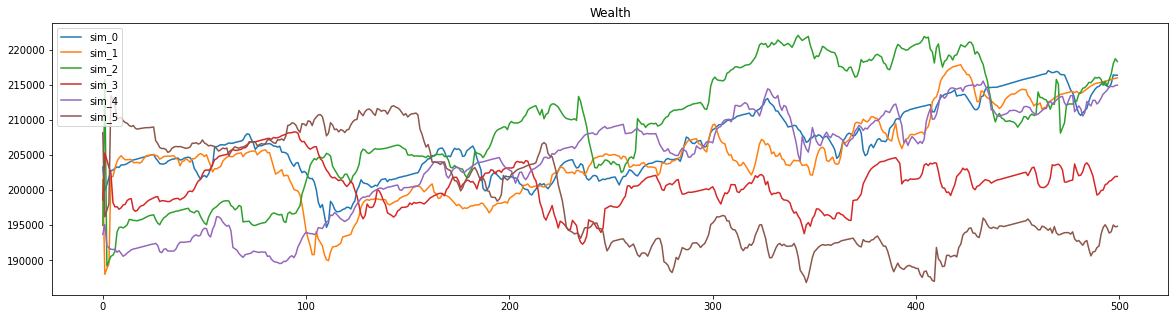

In [209]:
plot_wealth_by_time(predict_rl_states, va_agent_id)

In [ ]:
plot_holdings(predict_rl_states, va_agent_id)

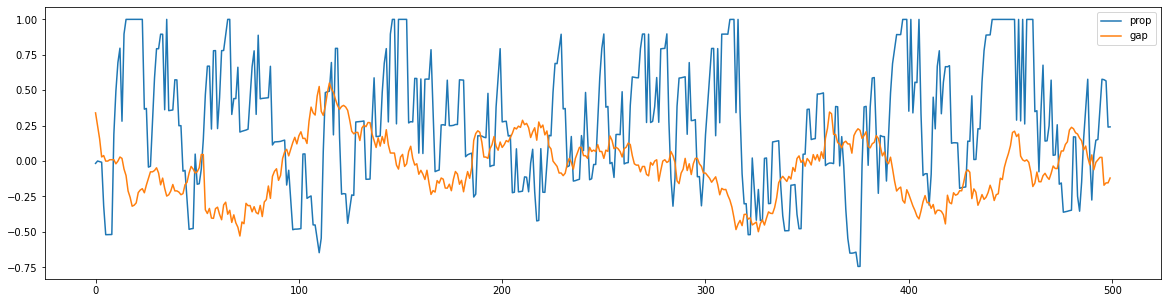

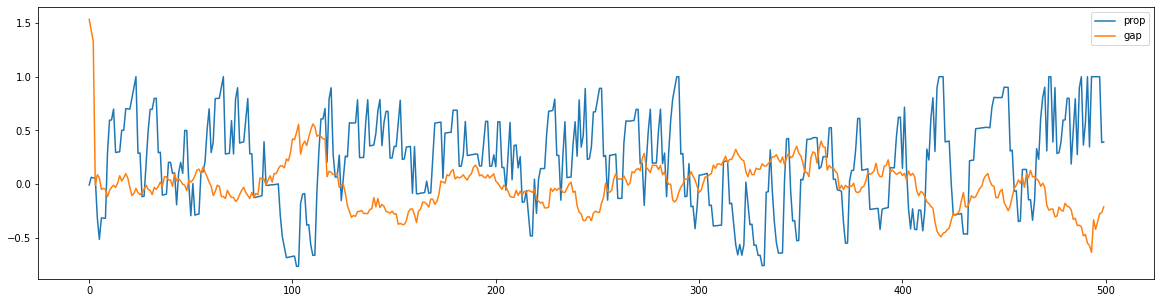

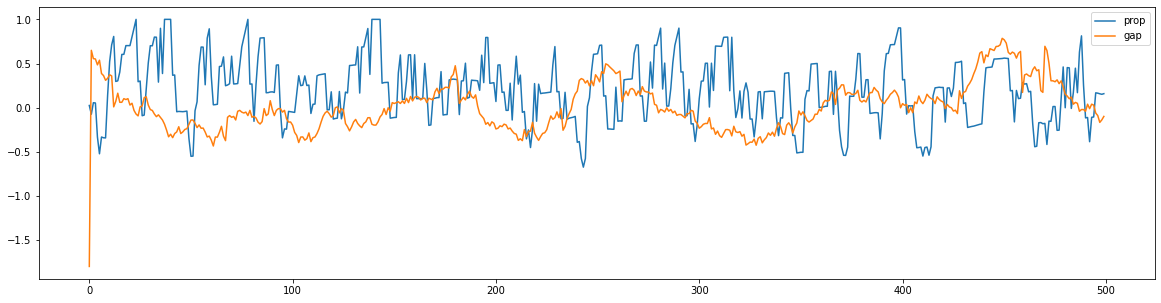

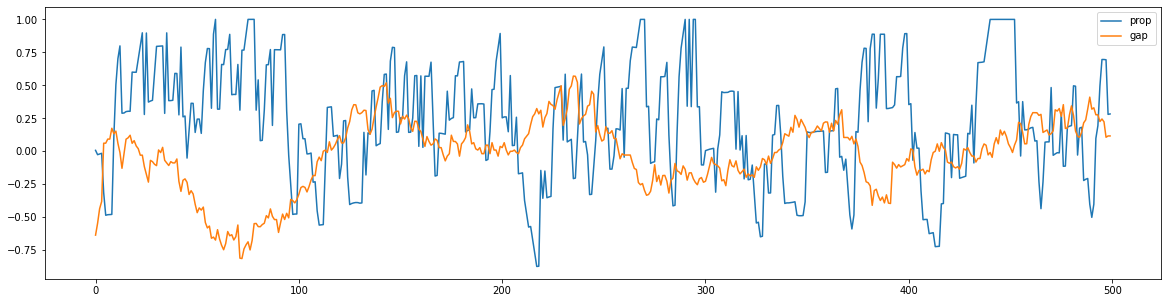

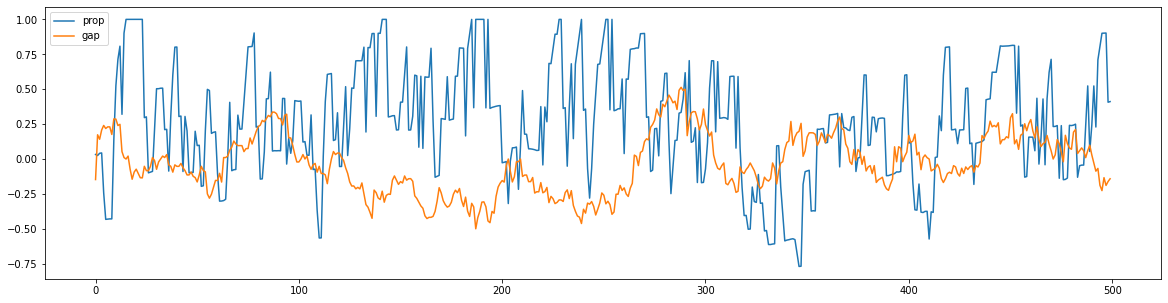

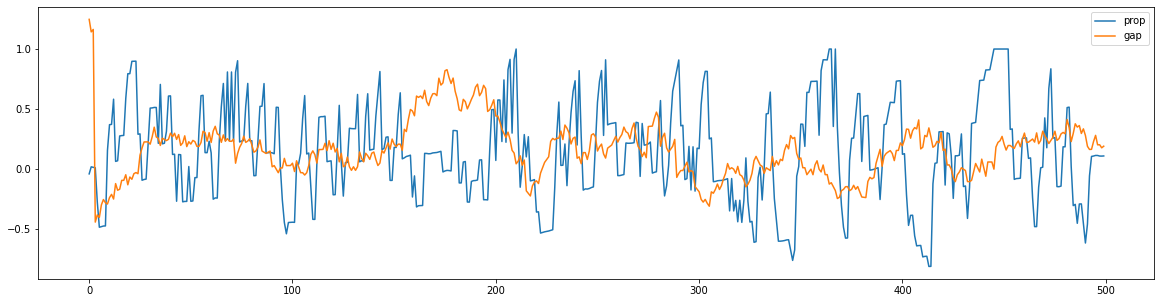

In [208]:
plot_obs_action(predict_rl_states, va_agent_id, ['prop', 'gap'])

In [ ]:
plot_obs_action(predict_rl_states, va_agent_id, ['prop', 'gap'])

In [ ]:
plot_action(predict_rl_states, predict_markets, va_agent_id)

In [289]:
value_corrs = []
# for sc_agent_id in predict_rl_states[0].keys():
va_agent_id = f'ppo_va_1_0'
for rl_states in predict_rl_states:
    gap = []
    portfolio = []
    agent_states = rl_states[va_agent_id]['states'][:1000]
    portfolio += [s['observations'][0] for s in agent_states]
    gap += [s['observations'][1] for s in agent_states]
    gap_array = np.array(gap)
    portfolio_array = np.array(portfolio)
    gap_corr = np.corrcoef(gap_array, -portfolio_array)
    print(gap_corr)
    print(scipy.stats.spearmanr(gap_array, -portfolio_array))
    

KeyError: 'ppo_va_1_0'

#### Scaling

In [ ]:
sc_agent_id = sample_agent_id(sc_group_name, sc_agent_number)

In [ ]:
plot_wealth_by_time(predict_rl_states, sc_agent_id)

In [ ]:
plot_holdings(predict_rl_states, sc_agent_id)

In [ ]:
plot_action(predict_rl_states, predict_markets, sc_agent_id)

In [ ]:
cal_sc_good_action(predict_rl_states, predict_markets, sc_agent_id)

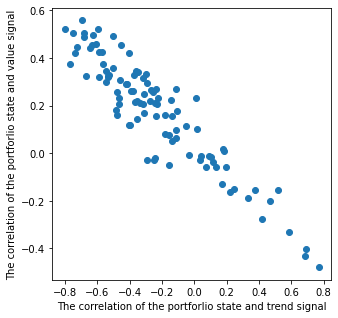

SpearmanrResult(correlation=-0.891161116111611, pvalue=2.0713916215615466e-35)

In [337]:
trend_corrs = []
value_corrs = []
# for sc_agent_id in predict_rl_states[0].keys():
for i in range(100):
    sc_agent_id = f'ppo_sc_100_{i}'
    trend = []
    value = []
    portfolio = []
    for rl_states in predict_rl_states:
        agent_states = rl_states[sc_agent_id]['states']
        portfolio += [s['observations'][0] for s in agent_states]
        trend += [s['observations'][1] for s in agent_states]
        value += [s['observations'][2] for s in agent_states]
    trend_array = np.array(trend)
    value_array = np.array(value)
    portfolio_array = np.array(portfolio)
    trend_corr = np.corrcoef(trend_array, -portfolio_array)
    value_corr = np.corrcoef(value_array, -portfolio_array)
    trend_corrs.append(trend_corr[0][1].item())
    value_corrs.append(value_corr[0][1].item())
num_agent = len(predict_rl_states[0].keys())
plt.figure(figsize = [5, 5])
plt.scatter(trend_corrs, value_corrs)
plt.xlabel('The correlation of the portforlio state and trend signal')
plt.ylabel('The correlation of the portforlio state and value signal')
plt.show()
scipy.stats.spearmanr(trend_corrs, value_corrs)

In [364]:
predict_rl_states[0]['ppo_sc_100_0']['states']

[{'observations': [-0.2789577945303472,
   0.2003363363363368,
   0.2552552552552546],
  'agent_state': {'cash': 104828, 'TSMC': 18, 'wealth': 290768.0}},
 {'observations': [-0.2634552148618645,
   0.09982053838484453,
   0.2243270189431705],
  'agent_state': {'cash': 104828, 'TSMC': 18, 'wealth': 284648.0}},
 {'observations': [-0.5481803145412241,
   0.2812116402116407,
   0.23809523809523833],
  'agent_state': {'cash': 64467.44, 'TSMC': 18, 'wealth': 285368.0}},
 {'observations': [-0.26698163958248916,
   0.460780519907864,
   0.19249753208292267],
  'agent_state': {'cash': 104919.84999999999,
   'TSMC': 12.0,
   'wealth': 286268.0}},
 {'observations': [0.15362025009760316,
   0.5556261437908507,
   0.13235294117647037],
  'agent_state': {'cash': 165694.38999999998,
   'TSMC': 12.0,
   'wealth': 287259.85}},
 {'observations': [-0.20485997662085692, 0.5534244791666677, 0.0732421875],
  'agent_state': {'cash': 114537.68999999999,
   'TSMC': 12.0,
   'wealth': 288094.39}},
 {'observatio

In [375]:
risk_free_rate = 0.004
for rl_state in predict_rl_states:
    for agent_id in predict_rl_states[0].keys():
        agent_wealth = [agent_state['agent_state']['wealth'] for agent_state in rl_state[agent_id]['states']]
        wealth_array = np.array(agent_wealth)
        d_ret = (wealth_array[1:] - wealth_array[-1]) / wealth_array[-1]
        sharpe = ((np.mean(d_ret) - risk_free_rate) / np.std(d_ret))*250
        print(sharpe)

-377.7389017887588
-565.0223734743604
-466.93323977221326
-596.524573349576
-651.3211113236868
-525.3454360728322
-569.132365393754
-574.3489676612346
-566.0331596374801
-568.5927694323992
-495.2416600233972
-638.8393865180706
-514.8753645108784
-630.1472602880765
-551.0026709321626
-591.9307735644649
-435.87734932094
-523.6971892024334
-625.8231724935932
-575.7286084699336
-342.59067727685886
-582.5045289630959
-562.5710677326069
-656.0141374570169
-556.6605404724969
-530.1724265377848
-469.73275290171665
-667.4678891858679
-568.5351429289333
-592.4596395895111
-562.9683173984229
-570.6020686743241
-418.7093773105946
-546.5742832024627
-605.7063495153203
-516.1363042509224
-507.81422781372356
-592.6041206597645
-382.1359350807506
-629.7913109877802
-583.6451381889415
-560.3154277836361
-421.05296553497834
-579.9314824957128
-619.4963357667081
-249.33090282794632
-474.64948010822314
-524.373895346965
-495.71079106243013
-537.2232990700677
-580.4322110010947
-550.7731158534385
-446.9025

In [369]:
np.std(d_ret)

0.04282265936292526

In [360]:
np.diff(agent_wealth)

58240.0

In [355]:
rl_state[agent_id]['states']

[{'observations': [-0.2789577945303472,
   0.2003363363363368,
   0.2552552552552546],
  'agent_state': {'cash': 104828, 'TSMC': 18, 'wealth': 290768.0}},
 {'observations': [-0.2634552148618645,
   0.09982053838484453,
   0.2243270189431705],
  'agent_state': {'cash': 104828, 'TSMC': 18, 'wealth': 284648.0}},
 {'observations': [-0.5481803145412241,
   0.2812116402116407,
   0.23809523809523833],
  'agent_state': {'cash': 64467.44, 'TSMC': 18, 'wealth': 285368.0}},
 {'observations': [-0.26698163958248916,
   0.460780519907864,
   0.19249753208292267],
  'agent_state': {'cash': 104919.84999999999,
   'TSMC': 12.0,
   'wealth': 286268.0}},
 {'observations': [0.15362025009760316,
   0.5556261437908507,
   0.13235294117647037],
  'agent_state': {'cash': 165694.38999999998,
   'TSMC': 12.0,
   'wealth': 287259.85}},
 {'observations': [-0.20485997662085692, 0.5534244791666677, 0.0732421875],
  'agent_state': {'cash': 114537.68999999999,
   'TSMC': 12.0,
   'wealth': 288094.39}},
 {'observatio

In [ ]:
for rl_state in predict_rl_states:
    pass

In [ ]:
for rl_state in predict_rl_states:
    for i, item in enumerate(['opt_utility', 'pes_utility', 'fud_utility']):
        l = [state['observations'][i] for state in rl_state[sc_agent_id]['states']]
        plt.plot(l, label = item)
    plt.legend()
    plt.show()


## Agent

In [ ]:
agent = pd.read_json(agent_path)
group_names = agent.columns
num_of_timesteps = len(agent[group_names[0]]['cash'])

In [ ]:
# Holdings
for i, rl_state in enumerate(rl_states):
    agent_state = rl_state[agent_id]['states']
    cash = [state['cash'] for state in agent_state]
    holding = [state['TSMC'] for state in agent_state]
    wealth = [state['wealth'] for state in agent_state]
    plt.plot(wealth, label = f"sim_{i}")
    plt.legend()

In [ ]:
# Holdings
agent_state = rl_states[-1][agent_id]['states']
cash = [state['cash'] for state in agent_state]
holding = [state['TSMC'] for state in agent_state]
wealth = [state['wealth'] for state in agent_state]
plt.plot(cash, label = "Cash")
plt.plot(wealth, label = "Wealth")
plt.legend()
plt.show()
plt.plot(holding, label = "TSMC")
plt.legend()

### Holdings

#### Initial state

In [ ]:
num_agent = 0
total_cash, total_TSMC = 0, 0
zi_cash, zi_TSMC = 0, 0
for group_name in group_names:
    if 'dh' in group_name:
        continue
    elif 'zi' in group_name:
        zi_cash += sum(agent[group_name]['initial_cash_by_agent'])
        zi_TSMC += sum([i['TSMC'] for i in agent[group_name]['initial_security_by_agent']])
    else:
        total_cash += sum(agent[group_name]['initial_cash_by_agent'])
        total_TSMC += sum([i['TSMC'] for i in agent[group_name]['initial_security_by_agent']])
        num_agent += len(agent[group_name]['initial_cash_by_agent'])

print(f"Number of agents: {num_agent}")
print(f"Total TSMC: {total_TSMC} Total cash: {total_cash}")
print(f"Average TSMC: {total_TSMC // num_agent} Average cash: {total_cash // num_agent}")
print(f"ZI TSMC: {zi_TSMC} ZI cash: {zi_cash}")
if 'dh_1' in group_names:
    print(f"Dahoo cash: {agent['dh_1']['initial_cash_by_agent'][0]}")

#### Wealth

In [ ]:
# for agent_type in agent.columns:
for group_name in agent.columns:
    plt.figure(figsize=(20, 10))
    plt.plot(agent[group_name]['wealth'])
    plt.title(group_name)
    plt.show()

In [ ]:
# normalize 
wealth = np.array([agent[group_name]['wealth'] for group_name in group_names])
std_wealth = (wealth - wealth[:, 0].reshape(-1, 1)) / wealth[:, 0].reshape(-1, 1)

plt.figure(figsize=(30, 20))
for i, group_name in enumerate(agent.columns):
    plt.plot(std_wealth[i], label = group_names[i])
plt.legend()

#### Cash

In [ ]:
plt.figure(figsize=(30, 10))
for i, group_name in enumerate(agent.columns):
    plt.plot(agent[group_name]['cash'], label = group_names[i])
plt.legend()
plt.show()

#### Security

In [ ]:
plt.figure(figsize=(20, 10))
for i, group_name in enumerate(agent.columns):
    plt.plot(agent[group_name]['TSMC'], label = group_names[i])
plt.legend()
plt.show()

#### Portfolio

In [ ]:
plt.figure(figsize=(20, 10))

close_price = tsmc['close'].to_numpy()
for group_name in group_names:
    security_value = close_price * np.array(agent[group_name]['TSMC']) * 100
    security_propotion = security_value / (np.array(agent[group_name]['cash'])  + security_value)
    plt.plot(security_propotion)
    plt.title(group_name, size = 20)
    plt.show()

In [ ]:
# baseline_return = pow(1.01, 100) / 2
# for group_name in group_names:
#     plt.figure(figsize=(20, 10))
#     plt.axhline(y = baseline_return)
#     plt.scatter(agent[group_name]['initial_wealth_by_agent'], np.array(agent[group_name]['returns_by_agent']))
#     plt.xlabel('Initial wealth')
#     plt.ylabel('Return')
#     plt.title(f"{group_name}")
#     plt.show()

#### Average cost

In [ ]:
plt.figure(figsize=(20, 10))
for i, group_name in enumerate(agent.columns):
    plt.plot(agent[group_name]['average_cost'], label = group_names[i])
plt.legend()

### Orders

#### Number

#### Each group

In [ ]:
from collections import defaultdict

t = list(group_names)
for group_name in group_names:
    if 'zi' in group_name:
        continue
    bids_timestep, bids_price, bids_volume, asks_timestep, asks_price, asks_volume = [], [], [], [], [], []
    bids_price_volume = defaultdict(float)
    asks_price_volume = defaultdict(float)
    
    for i in range(len(agent[group_name]['timestep_bid'])):
        for price, volume in agent[group_name]['timestep_bid'][i].items():
            bids_timestep.append(i)
            bids_price.append(float(price))
            bids_volume.append(volume)
            bids_price_volume[float(price)] += volume
        for price, volume in agent[group_name]['timestep_ask'][i].items():
            asks_timestep.append(i)
            asks_price.append(float(price))
            asks_volume.append(volume)
            asks_price_volume[float(price)] += volume
    
    bids_size = [ 400*(volume - min(bids_volume)) / max(bids_volume) - min(bids_volume) for volume in bids_volume]
    asks_size = [ 400*(volume - min(asks_volume)) / max(asks_volume) - min(asks_volume) for volume in asks_volume]
    plt.plot(tsmc['close'])
    plt.scatter(bids_timestep, bids_price, s = bids_size, c = 'r', marker = 6)
    plt.scatter(asks_timestep, asks_price, s = asks_size, c = 'g', marker = 7)
    plt.title(group_name)
    plt.show()
    plt.bar(list(bids_price_volume.keys()), list(bids_price_volume.values()), color = 'r')
    plt.bar(list(asks_price_volume.keys()), np.array(list(asks_price_volume.values())) * -1, color = 'g')
    plt.show()


#### Propotion

In [ ]:
group_bids_volume = [agent.loc['group_bids_volume', group_name] for group_name in group_names]
group_bids_volume = np.array(group_bids_volume).T
group_bids_volume = group_bids_volume / group_bids_volume.sum(axis = 1).reshape(-1, 1)
for i in range(len(group_names)):
#     if group_names[i] == 'zi_1000':
#         continue
    plt.plot(group_bids_volume[:, i], label = group_names[i])
# plt.ylim(0, 0.1)
plt.legend()

In [ ]:
group_asks_volume = [agent.loc['group_asks_volume', group_name] for group_name in group_names]
group_asks_volume = np.array(group_asks_volume).T
group_asks_volume = group_asks_volume / group_asks_volume.sum(axis = 1).reshape(-1, 1)
for i in range(len(group_names)):
#     if group_names[i] == 'zi_1000':
#         continue
    plt.plot(-1 * group_asks_volume[:, i], label = group_names[i])

# plt.ylim(-0.3, 0.2)
plt.legend()

## RL Agent

In [ ]:
import random

markets, agents, rl_states, lengths, timesteps = [], [], [], [], []
for _dir in validate_dirs:
    record_dir = result_dir / 'validate' / _dir
    security_path = record_dir / "TSMC.json"
    agent_path = record_dir / "agent.json"
    rl_path = record_dir / 'rl_agent.json'
    config_path = result_dir / 'config.json'
    market = json.loads(security_path.read_text())
    markets.append(market)
    agents.append(json.loads(agent_path.read_text()))
    rl_states.append(json.loads(rl_path.read_text()))
    lengths.append(len(market['price']))
    timesteps.append([i for i in range(len(market['price']))])

In [ ]:
print(f"Average length: {sum(lengths) / len(lengths)}")

In [ ]:
for timestep, action in enumerate(actions):
    if action[0] == 0:
        bid_x.append(timestep + 100)
        bid_y.append(action[1]*0.1)
        bid_colors.append('r')
        bid_sizes.append(base_size * action[2])
    elif action[0] == 1:
        ask_x.append(timestep + 100)
        ask_y.append(action[1]*0.1)
        ask_colors.append('g')
        ask_sizes.append(base_size * action[2])

In [ ]:
for group in config['Agent']['RLAgent']:
    group_name = group['name']
    group_number = group['number']
    sample_id = f"{group_name}_{group_number}_{random.randint(0, group_number-1)}"
    state = rl_states[sample_id]
    print(sample_id)
    holdings_df = pd.DataFrame(rl_states[sample_id]['states'])
    plt.plot(holdings_df.wealth / holdings_df.wealth[0], label = "wealth")
    plt.plot(holdings_df.TSMC / holdings_df.TSMC[0], label = "TSMC")
    plt.plot(holdings_df.cash / holdings_df.cash[0], label = "cash")
    plt.legend()
    plt.show()
    
    actions = rl_states[sample_id]['actions']
    actions_df = pd.DataFrame(rl_states[sample_id]['actions'], columns = ['action', 'tick', 'volume'])
    print(f"Bid rate: {actions_df.action.eq(0).mean()}, Ask rate: {actions_df.action.eq(1).mean()}, Hold rate: {actions_df.action.eq(2).mean()}")
    bid_x, bid_y = [], []
    ask_x, ask_y = [], []
    bid_sizes, ask_sizes = [], []
    bid_colors, ask_colors = [], []
    base_size = 200
    for timestep, action in enumerate(actions):
        if action[0] == 0:
            bid_x.append(timestep + 100)
            bid_y.append(action[1]*0.1)
            bid_colors.append('r')
            bid_sizes.append(base_size * action[2])
        elif action[0] == 1:
            ask_x.append(timestep + 100)
            ask_y.append(action[1]*0.1)
            ask_colors.append('g')
            ask_sizes.append(base_size * action[2])
            
    x = np.arange(2500)
    plt.figure(figsize=(80, 20))
    plt.plot(x, market['price'][100:])
    plt.scatter(bid_x, a, s = bid_sizes, c = bid_colors, marker = 6)
    plt.scatter(ask_x, ask_y, s = ask_sizes, c = ask_colors, marker = 7)
    plt.show()

        
    break

### Relation of reward and performance

In [ ]:
agent_ids = list(rl_states.keys())
agent_id = random.sample(agent_ids, 1)
state = rl_states[agent_id]
rewards = state['rewards']


In [ ]:
plt.plot(timesteps, rewards, label = ['action', 'wealth', 'is_valid'])
plt.legend()

In [ ]:
sim_num = len(train_dirs)
length = len(market['price'][100:])
timesteps = [i for i in range(length)]
agent_ids = list(rl_states.keys())
agent_id = random.sample(agent_ids, 1)[0]

total_rewards = []
for i in range(sim_num):
    record_dir = result_dir / 'train' / f'sim_{i}'
#     security_path = record_dir / "TSMC.json"
#     agent_path = record_dir / "agent.json"
    rl_path = record_dir / 'rl_agent.json'
#     market = json.loads(security_path.read_text())
#     agents = json.loads(agent_path.read_text())
    rl_states = json.loads(rl_path.read_text())
    total_rewards.append(rl_states[agent_id]['rewards'])


In [ ]:
action_rewards = []
wealth_rewards = []
valid_rewards = []

tr = np.array(total_rewards)
total_reward_by_type = tr.reshape([-1, 3])

In [ ]:
plt.plot(total_reward_by_type, label = ['action', 'wealth', 'is_valid'])
plt.legend()

### Orders

In [ ]:
agents.keys()

In [ ]:
rl_states['ppo_tr_100_0']

### Distribution of actions along times from random agent

In [ ]:
prices = market['price'][100:]
bids = market['bid_five_price']
asks = market['ask_five_price']
bid_or_asks = []
agent_id = random.sample(agent_ids, 1)[0]
state = rl_states[agent_id]
counters = []
for agent_id, state in rl_states.items():
    bid_or_asks = []
    for i, action in enumerate(state['actions']):
        bid_or_ask = action[0]
        ticks = action[1]
        volume = action[2] + 1
        current_price = prices[i]
        tick_size = 0.1

        if bid_or_ask == 2:
            pass
        elif bid_or_ask == 0:
            # bid
            best_bids = list(bids[i])
            best_bid = current_price if len(best_bids) == 0 else float(best_bids[0])
            price = round(best_bid + (4-ticks) * tick_size, 2)

        elif bid_or_ask == 1:
            # ask
            best_asks = list(asks[i])
            best_ask = current_price if len(best_asks) == 0 else float(best_asks[0])
            price = round(best_ask + (ticks-4) * tick_size, 2)
        bid_or_asks.append(bid_or_ask)


    counter = {0: 0, 1: 0, 2: 0}
    for a in bid_or_asks:
        counter[a] += 1
    counters.append(counter)


In [ ]:
hold_times = {i: 0 for i in range(length+1)}
bid_times = {i: 0 for i in range(length+1)}
ask_times = {i: 0 for i in range(length+1)}

for counter in counters:
    bid_times[counter[0]] += 1
    ask_times[counter[1]] += 1
    hold_times[counter[2]] += 1
    

In [ ]:
plt.plot(timesteps, list(hold_times.values()), 'r')
plt.plot(timesteps, list(bid_times.values()), 'b')
plt.plot(timesteps, list(ask_times.values()), 'g')

In [ ]:
# append data for maintaining the same length
rl_states['states'][-1]['action'] = rl_states['states'][-2]['action']
rl_states['states'][-1]['reward'] = rl_states['states'][-2]['reward']

In [ ]:
rl_dict = {}
for k, v in rl_states['states'][0].items():
    if type(v) != dict:
        rl_dict[k] = []
    else:
        for key in v.keys():
            rl_dict[key] = []

In [ ]:
for state in rl_states['states']:
    for k, v in state.items():
        if type(v) != dict:
            rl_dict[k].append(v)
        else:
            for key, value in v.items():
                rl_dict[key].append(value)

In [ ]:
rl_df = pd.DataFrame(rl_dict)
rl_df

Reward

In [ ]:
plt.plot(rl_df.wealth / rl_df.wealth[0])
plt.plot(rl_df.wealth_reward)

Action

In [ ]:
'''
1. Discrete 3 - BUY[0], SELL[1], HOLD[2]
2. Discrete 9 - TICK_-4[0], TICK_-3[1], TICK_-2[2], TICK_-1[3], TICK_0[4], TICK_1[5], TICK_2[6], TICK_3[7], TICK_4[8]
3. Discrete 5 - VOLUME_1[0], VOLUME_2[1], VOLUME_3[2], VOLUME_4[3], VOLUME_5[4],
'''
valid_action_rate = rl_df.is_valid.mean()
bid_rate = rl_df.action.apply(lambda x: int(x[0]) == 0).mean()
ask_rate = rl_df.action.apply(lambda x: int(x[1]) == 0).mean()
hold_rate = rl_df.action.apply(lambda x: int(x[2]) == 0).mean()
print(f"Bid rate: {bid_rate}\nAsk rate: {ask_rate}\nHold rate: {hold_rate}\nValid action rate: {valid_action_rate}")

In [ ]:
rl_orders = rl_states['orders']

In [ ]:
bid_x, bid_y = [], []
ask_x, ask_y = [], []
bid_sizes, ask_sizes = [], []
bid_colors, ask_colors = [], []
base_size = 200
for order in rl_orders:
    if order['bid_or_ask'] == 'BID':
        if order['time'] > 5000 and order['time'] < 5100:
            bid_x.append(order['time'])
            bid_y.append(order['price'])
            bid_colors.append('r')
            bid_sizes.append(base_size * order['volume'])
    if order['bid_or_ask'] == 'ASK':
        if order['time'] > 5000 and order['time'] < 5100:
            ask_x.append(order['time'])
            ask_y.append(order['price'])
            ask_colors.append('g')  
            ask_sizes.append(base_size * order['volume'])

In [ ]:
x = np.arange(len(tsmc['close']))
plt.figure(figsize=(80, 20))
plt.plot(x[4999: 5101], tsmc['close'][4999:5101])
plt.scatter(bid_x, bid_y, s = bid_sizes, c = bid_colors, marker = 6)
plt.scatter(ask_x, ask_y, s = ask_sizes, c = ask_colors, marker = 7)
plt.show()